# Transfer Learning and Fine-Tuning

**Learning Objectives**

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


## Introduction 
In this notebook, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

Each learning objective will correspond to a __#TODO__ in the notebook where you will complete the notebook cell's code before running. Refer to the [solution](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/image_understanding/solutions/transfer_learning.ipynb) for reference. 

In [ ]:
# Use the chown command to change the ownership of repository to user.
!sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

In [3]:
!pip install -q tf-nightly

You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


Please re-run the above cell if you are getting any incompatible warnings and errors.

In [4]:
# You can use any Python source file as a module by executing an import statement in some other Python source file.
# The import statement combines two operations; it searches for the named module, then it binds the results of that search
# to a name in the local scope.
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

This notebook uses TF2.x.
Please check your tensorflow version using the cell below.

In [ ]:
# Show the currently installed version of TensorFlow
print("TensorFlow version: ",tf.version.VERSION)

TensorFlow version:  2.5.0-dev20210114


## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.preprocessing.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [5]:
# Downloads a file from a URL if it not already in the cache.
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

    8192/68606236 [..............................] - ETA: 1s

 4202496/68606236 [>.............................] - ETA: 4s

15917056/68606236 [=====>........................] - ETA: 1s

30851072/68606236 [============>.................] - ETA: 0s

33562624/68606236 [=============>................] - ETA: 0s

48046080/68606236 [====================>.........] - ETA: 0s

50339840/68606236 [=====================>........] - ETA: 0s

65036288/68606236 [===========================>..] - ETA: 0s

68608000/68606236 [==============================] - 1s 0us/step


Found 2000 files belonging to 2 classes.


In [6]:
# Generates a `tf.data.Dataset` from image files in a directory.
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

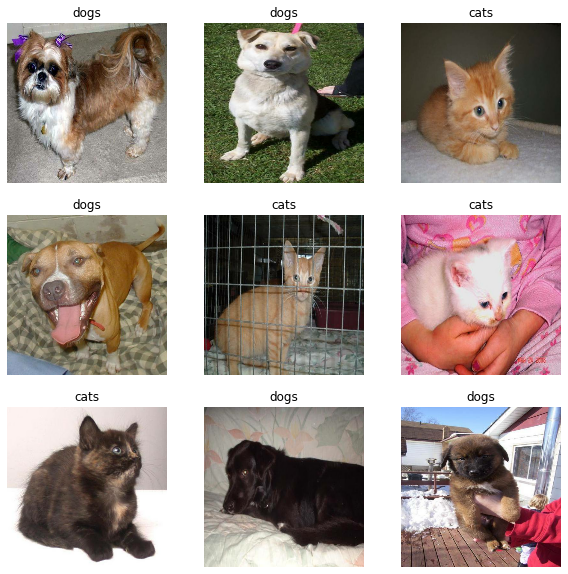

In [7]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
# Show the first nine images and labels from the training set
# TODO
# TODO: Your code goes here
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contains a test set, you will create one. To do so, determine how many batches of data are available in the validation set using ```tf.data.experimental.cardinality```, then move 20% of them to a test set.

In [8]:
# Returns the cardinality of dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [9]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `model.fit`. They are inactive when the model is used in inference mode in `model.evaulate` or `model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

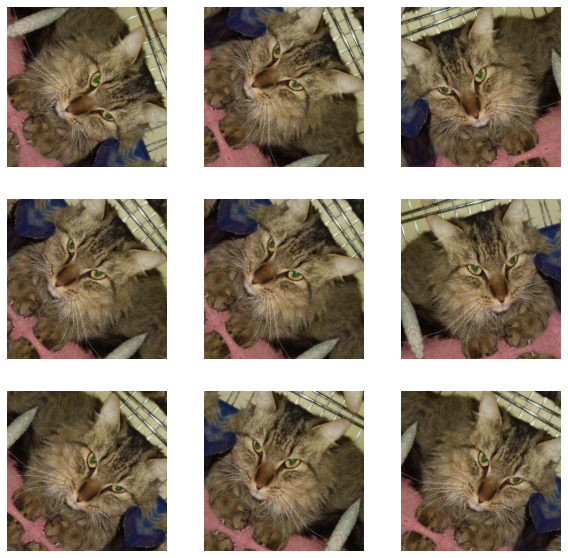

In [12]:
# Use `take(1)` to only pull one example from the dataset.
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel vaues in `[-1,1]`, but at this point, the pixel values in your images are in `[0-255]`. To rescale them, use the preprocessing method included with the model.

In [13]:
# Preprocesses a tensor or Numpy array encoding a batch of images.
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0,255]` to `[-1, 1]` using a [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) layer.

In [14]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1,1]` or `[0,1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [15]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
# TODO
# TODO: Your code goes here


   8192/9406464 [..............................] - ETA: 0s

4202496/9406464 [============>.................] - ETA: 0s

9412608/9406464 [==============================] - 1s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [17]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [18]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [19]:
# Global average pooling operation for spatial data.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [20]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [21]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [24]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [25]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

 1/26 [>.............................] - ETA: 51s - loss: 0.8548 - accuracy: 0.5000

 2/26 [=>............................] - ETA: 4s - loss: 0.8792 - accuracy: 0.4922 

 3/26 [==>...........................] - ETA: 4s - loss: 0.8956 - accuracy: 0.4670

 4/26 [===>..........................] - ETA: 4s - loss: 0.9081 - accuracy: 0.4479

 5/26 [====>.........................] - ETA: 4s - loss: 0.9132 - accuracy: 0.4346

 6/26 [=====>........................] - ETA: 4s - loss: 0.9180 - accuracy: 0.4238

 7/26 [=======>......................] - ETA: 3s - loss: 0.9195 - accuracy: 0.4168

 8/26 [========>.....................] - ETA: 3s - loss: 0.9213 - accuracy: 0.4111

 9/26 [=========>....................] - ETA: 3s - loss: 0.9207 - accuracy: 0.4063

10/26 [==========>...................] - ETA: 3s - loss: 0.9205 - accuracy: 0.4026

11/26 [===========>..................] - ETA: 3s - loss: 0.9189 - accuracy: 0.4006

12/26 [============>.................] - ETA: 2s - loss: 0.9183 - accuracy: 0.3984

13/26 [==============>...............] - ETA: 2s - loss: 0.9179 - accuracy: 0.3966

14/26 [===============>..............] - ETA: 2s - loss: 0.9170 - accuracy: 0.3951

15/26 [================>.............] - ETA: 2s - loss: 0.9162 - accuracy: 0.3933

16/26 [=================>............] - ETA: 2s - loss: 0.9153 - accuracy: 0.3922

17/26 [==================>...........] - ETA: 1s - loss: 0.9141 - accuracy: 0.3918

18/26 [===================>..........] - ETA: 1s - loss: 0.9132 - accuracy: 0.3914

19/26 [====================>.........] - ETA: 1s - loss: 0.9127 - accuracy: 0.3911

20/26 [======================>.......] - ETA: 1s - loss: 0.9123 - accuracy: 0.3905

21/26 [=======================>......] - ETA: 1s - loss: 0.9121 - accuracy: 0.3897

22/26 [========================>.....] - ETA: 0s - loss: 0.9121 - accuracy: 0.3887

23/26 [=========================>....] - ETA: 0s - loss: 0.9123 - accuracy: 0.3878

24/26 [==========================>...] - ETA: 0s - loss: 0.9124 - accuracy: 0.3871

25/26 [===========================>..] - ETA: 0s - loss: 0.9125 - accuracy: 0.3865

26/26 [==============================] - ETA: 0s - loss: 0.9125 - accuracy: 0.3861

26/26 [==============================] - 7s 199ms/step - loss: 0.9126 - accuracy: 0.3857


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.91
initial accuracy: 0.38


In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


 1/63 [..............................] - ETA: 2:58 - loss: 0.9614 - accuracy: 0.3750

 2/63 [..............................] - ETA: 14s - loss: 0.8917 - accuracy: 0.4688 

 3/63 [>.............................] - ETA: 13s - loss: 0.8900 - accuracy: 0.4375

 4/63 [>.............................] - ETA: 13s - loss: 0.8678 - accuracy: 0.4609

 5/63 [=>............................] - ETA: 13s - loss: 0.8548 - accuracy: 0.4812

 6/63 [=>............................] - ETA: 12s - loss: 0.8460 - accuracy: 0.4844

 7/63 [==>...........................] - ETA: 12s - loss: 0.8136 - accuracy: 0.5223

 8/63 [==>...........................] - ETA: 12s - loss: 0.8102 - accuracy: 0.5156

 9/63 [===>..........................] - ETA: 12s - loss: 0.8315 - accuracy: 0.4896

10/63 [===>..........................] - ETA: 11s - loss: 0.8352 - accuracy: 0.4750

11/63 [====>.........................] - ETA: 11s - loss: 0.8472 - accuracy: 0.4773

12/63 [====>.........................] - ETA: 11s - loss: 0.8334 - accuracy: 0.4896

13/63 [=====>........................] - ETA: 11s - loss: 0.8324 - accuracy: 0.4880

14/63 [=====>........................] - ETA: 10s - loss: 0.8351 - accuracy: 0.4821

15/63 [======>.......................] - ETA: 10s - loss: 0.8357 - accuracy: 0.4771

16/63 [======>.......................] - ETA: 10s - loss: 0.8348 - accuracy: 0.4766

17/63 [=======>......................] - ETA: 10s - loss: 0.8302 - accuracy: 0.4779

18/63 [=======>......................] - ETA: 9s - loss: 0.8417 - accuracy: 0.4740 

19/63 [========>.....................] - ETA: 9s - loss: 0.8378 - accuracy: 0.4737

20/63 [========>.....................] - ETA: 9s - loss: 0.8409 - accuracy: 0.4750

21/63 [=========>....................] - ETA: 9s - loss: 0.8395 - accuracy: 0.4717

22/63 [=========>....................] - ETA: 9s - loss: 0.8370 - accuracy: 0.4759

23/63 [=========>....................] - ETA: 8s - loss: 0.8337 - accuracy: 0.4783

24/63 [==========>...................] - ETA: 8s - loss: 0.8269 - accuracy: 0.4870

25/63 [==========>...................] - ETA: 8s - loss: 0.8244 - accuracy: 0.4863

26/63 [===========>..................] - ETA: 8s - loss: 0.8240 - accuracy: 0.4856

27/63 [===========>..................] - ETA: 7s - loss: 0.8261 - accuracy: 0.4826

28/63 [============>.................] - ETA: 7s - loss: 0.8340 - accuracy: 0.4766

29/63 [============>.................] - ETA: 7s - loss: 0.8328 - accuracy: 0.4806

30/63 [=============>................] - ETA: 7s - loss: 0.8279 - accuracy: 0.4812

31/63 [=============>................] - ETA: 7s - loss: 0.8262 - accuracy: 0.4839

32/63 [==============>...............] - ETA: 6s - loss: 0.8246 - accuracy: 0.4873

33/63 [==============>...............] - ETA: 6s - loss: 0.8251 - accuracy: 0.4858

34/63 [===============>..............] - ETA: 6s - loss: 0.8209 - accuracy: 0.4871

35/63 [===============>..............] - ETA: 6s - loss: 0.8172 - accuracy: 0.4884

36/63 [================>.............] - ETA: 5s - loss: 0.8091 - accuracy: 0.4922

37/63 [================>.............] - ETA: 5s - loss: 0.8075 - accuracy: 0.4916

38/63 [=================>............] - ETA: 5s - loss: 0.8070 - accuracy: 0.4918

39/63 [=================>............] - ETA: 5s - loss: 0.8043 - accuracy: 0.4944

40/63 [==================>...........] - ETA: 5s - loss: 0.8027 - accuracy: 0.4945

41/63 [==================>...........] - ETA: 4s - loss: 0.8017 - accuracy: 0.4931

42/63 [===================>..........] - ETA: 4s - loss: 0.8025 - accuracy: 0.4926

43/63 [===================>..........] - ETA: 4s - loss: 0.8000 - accuracy: 0.4942

44/63 [===================>..........] - ETA: 4s - loss: 0.7981 - accuracy: 0.4943

45/63 [====================>.........] - ETA: 3s - loss: 0.7944 - accuracy: 0.4972

46/63 [====================>.........] - ETA: 3s - loss: 0.7931 - accuracy: 0.4993

47/63 [=====================>........] - ETA: 3s - loss: 0.7887 - accuracy: 0.5040

48/63 [=====================>........] - ETA: 3s - loss: 0.7873 - accuracy: 0.5052

49/63 [======================>.......] - ETA: 3s - loss: 0.7838 - accuracy: 0.5083

50/63 [======================>.......] - ETA: 2s - loss: 0.7824 - accuracy: 0.5081

51/63 [=======================>......] - ETA: 2s - loss: 0.7813 - accuracy: 0.5086

52/63 [=======================>......] - ETA: 2s - loss: 0.7779 - accuracy: 0.5102

53/63 [========================>.....] - ETA: 2s - loss: 0.7804 - accuracy: 0.5112

54/63 [========================>.....] - ETA: 1s - loss: 0.7800 - accuracy: 0.5098

55/63 [=========================>....] - ETA: 1s - loss: 0.7765 - accuracy: 0.5136

56/63 [=========================>....] - ETA: 1s - loss: 0.7762 - accuracy: 0.5151

57/63 [==========================>...] - ETA: 1s - loss: 0.7746 - accuracy: 0.5159

58/63 [==========================>...] - ETA: 1s - loss: 0.7717 - accuracy: 0.5189

59/63 [===========================>..] - ETA: 0s - loss: 0.7681 - accuracy: 0.5233

60/63 [===========================>..] - ETA: 0s - loss: 0.7686 - accuracy: 0.5250

61/63 [============================>.] - ETA: 0s - loss: 0.7670 - accuracy: 0.5272

62/63 [============================>.] - ETA: 0s - loss: 0.7659 - accuracy: 0.5282

63/63 [==============================] - ETA: 0s - loss: 0.7643 - accuracy: 0.5285

63/63 [==============================] - 22s 306ms/step - loss: 0.7643 - accuracy: 0.5285 - val_loss: 0.6197 - val_accuracy: 0.6324


Epoch 2/10


 1/63 [..............................] - ETA: 32s - loss: 0.5795 - accuracy: 0.6250

 2/63 [..............................] - ETA: 13s - loss: 0.5875 - accuracy: 0.6875

 3/63 [>.............................] - ETA: 13s - loss: 0.5770 - accuracy: 0.6875

 4/63 [>.............................] - ETA: 12s - loss: 0.5830 - accuracy: 0.6875

 5/63 [=>............................] - ETA: 12s - loss: 0.5985 - accuracy: 0.6687

 6/63 [=>............................] - ETA: 12s - loss: 0.5996 - accuracy: 0.6823

 7/63 [==>...........................] - ETA: 12s - loss: 0.5961 - accuracy: 0.6741

 8/63 [==>...........................] - ETA: 11s - loss: 0.6202 - accuracy: 0.6367

 9/63 [===>..........................] - ETA: 11s - loss: 0.6141 - accuracy: 0.6389

10/63 [===>..........................] - ETA: 11s - loss: 0.6201 - accuracy: 0.6406

11/63 [====>.........................] - ETA: 11s - loss: 0.6147 - accuracy: 0.6506

12/63 [====>.........................] - ETA: 11s - loss: 0.6147 - accuracy: 0.6510

13/63 [=====>........................] - ETA: 10s - loss: 0.6119 - accuracy: 0.6490

14/63 [=====>........................] - ETA: 10s - loss: 0.6250 - accuracy: 0.6339

15/63 [======>.......................] - ETA: 10s - loss: 0.6196 - accuracy: 0.6375

16/63 [======>.......................] - ETA: 10s - loss: 0.6129 - accuracy: 0.6465

17/63 [=======>......................] - ETA: 9s - loss: 0.6110 - accuracy: 0.6489 

18/63 [=======>......................] - ETA: 9s - loss: 0.6208 - accuracy: 0.6424

19/63 [========>.....................] - ETA: 9s - loss: 0.6153 - accuracy: 0.6546

20/63 [========>.....................] - ETA: 9s - loss: 0.6175 - accuracy: 0.6531

21/63 [=========>....................] - ETA: 8s - loss: 0.6115 - accuracy: 0.6577

22/63 [=========>....................] - ETA: 8s - loss: 0.6103 - accuracy: 0.6577

23/63 [=========>....................] - ETA: 8s - loss: 0.6093 - accuracy: 0.6576

24/63 [==========>...................] - ETA: 8s - loss: 0.6098 - accuracy: 0.6536

25/63 [==========>...................] - ETA: 8s - loss: 0.6116 - accuracy: 0.6525

26/63 [===========>..................] - ETA: 7s - loss: 0.6047 - accuracy: 0.6587

27/63 [===========>..................] - ETA: 7s - loss: 0.6072 - accuracy: 0.6551

28/63 [============>.................] - ETA: 7s - loss: 0.6056 - accuracy: 0.6574

29/63 [============>.................] - ETA: 7s - loss: 0.6068 - accuracy: 0.6509

30/63 [=============>................] - ETA: 7s - loss: 0.6042 - accuracy: 0.6510

31/63 [=============>................] - ETA: 6s - loss: 0.6043 - accuracy: 0.6502

32/63 [==============>...............] - ETA: 6s - loss: 0.6033 - accuracy: 0.6514

33/63 [==============>...............] - ETA: 6s - loss: 0.6013 - accuracy: 0.6534

34/63 [===============>..............] - ETA: 6s - loss: 0.5999 - accuracy: 0.6544

35/63 [===============>..............] - ETA: 6s - loss: 0.5963 - accuracy: 0.6589

36/63 [================>.............] - ETA: 5s - loss: 0.5975 - accuracy: 0.6562

37/63 [================>.............] - ETA: 5s - loss: 0.5949 - accuracy: 0.6571

38/63 [=================>............] - ETA: 5s - loss: 0.5930 - accuracy: 0.6612

39/63 [=================>............] - ETA: 5s - loss: 0.5901 - accuracy: 0.6627

40/63 [==================>...........] - ETA: 4s - loss: 0.5897 - accuracy: 0.6617

41/63 [==================>...........] - ETA: 4s - loss: 0.5888 - accuracy: 0.6616

42/63 [===================>..........] - ETA: 4s - loss: 0.5869 - accuracy: 0.6615

43/63 [===================>..........] - ETA: 4s - loss: 0.5858 - accuracy: 0.6642

44/63 [===================>..........] - ETA: 4s - loss: 0.5844 - accuracy: 0.6648

45/63 [====================>.........] - ETA: 3s - loss: 0.5814 - accuracy: 0.6667

46/63 [====================>.........] - ETA: 3s - loss: 0.5808 - accuracy: 0.6658

47/63 [=====================>........] - ETA: 3s - loss: 0.5815 - accuracy: 0.6642

48/63 [=====================>........] - ETA: 3s - loss: 0.5803 - accuracy: 0.6654

49/63 [======================>.......] - ETA: 3s - loss: 0.5801 - accuracy: 0.6652

50/63 [======================>.......] - ETA: 2s - loss: 0.5780 - accuracy: 0.6656

51/63 [=======================>......] - ETA: 2s - loss: 0.5795 - accuracy: 0.6654

52/63 [=======================>......] - ETA: 2s - loss: 0.5769 - accuracy: 0.6689

53/63 [========================>.....] - ETA: 2s - loss: 0.5746 - accuracy: 0.6710

54/63 [========================>.....] - ETA: 1s - loss: 0.5710 - accuracy: 0.6730

55/63 [=========================>....] - ETA: 1s - loss: 0.5687 - accuracy: 0.6739

56/63 [=========================>....] - ETA: 1s - loss: 0.5669 - accuracy: 0.6735

57/63 [==========================>...] - ETA: 1s - loss: 0.5648 - accuracy: 0.6760

58/63 [==========================>...] - ETA: 1s - loss: 0.5651 - accuracy: 0.6740

59/63 [===========================>..] - ETA: 0s - loss: 0.5663 - accuracy: 0.6727

60/63 [===========================>..] - ETA: 0s - loss: 0.5642 - accuracy: 0.6745

61/63 [============================>.] - ETA: 0s - loss: 0.5642 - accuracy: 0.6762

62/63 [============================>.] - ETA: 0s - loss: 0.5626 - accuracy: 0.6764

63/63 [==============================] - ETA: 0s - loss: 0.5608 - accuracy: 0.6780

63/63 [==============================] - 19s 301ms/step - loss: 0.5608 - accuracy: 0.6780 - val_loss: 0.4556 - val_accuracy: 0.7710


Epoch 3/10


 1/63 [..............................] - ETA: 32s - loss: 0.3677 - accuracy: 0.8750

 2/63 [..............................] - ETA: 13s - loss: 0.4320 - accuracy: 0.8281

 3/63 [>.............................] - ETA: 13s - loss: 0.4270 - accuracy: 0.8333

 4/63 [>.............................] - ETA: 12s - loss: 0.4557 - accuracy: 0.7812

 5/63 [=>............................] - ETA: 12s - loss: 0.4632 - accuracy: 0.7750

 6/63 [=>............................] - ETA: 12s - loss: 0.4782 - accuracy: 0.7656

 7/63 [==>...........................] - ETA: 12s - loss: 0.4899 - accuracy: 0.7411

 8/63 [==>...........................] - ETA: 12s - loss: 0.4881 - accuracy: 0.7461

 9/63 [===>..........................] - ETA: 11s - loss: 0.4789 - accuracy: 0.7465

10/63 [===>..........................] - ETA: 11s - loss: 0.4851 - accuracy: 0.7312

11/63 [====>.........................] - ETA: 11s - loss: 0.4901 - accuracy: 0.7188

12/63 [====>.........................] - ETA: 11s - loss: 0.4839 - accuracy: 0.7266

13/63 [=====>........................] - ETA: 11s - loss: 0.4806 - accuracy: 0.7308

14/63 [=====>........................] - ETA: 11s - loss: 0.4790 - accuracy: 0.7344

15/63 [======>.......................] - ETA: 10s - loss: 0.4720 - accuracy: 0.7417

16/63 [======>.......................] - ETA: 10s - loss: 0.4745 - accuracy: 0.7461

17/63 [=======>......................] - ETA: 10s - loss: 0.4679 - accuracy: 0.7500

18/63 [=======>......................] - ETA: 10s - loss: 0.4712 - accuracy: 0.7465

19/63 [========>.....................] - ETA: 10s - loss: 0.4712 - accuracy: 0.7484

20/63 [========>.....................] - ETA: 9s - loss: 0.4723 - accuracy: 0.7469 

21/63 [=========>....................] - ETA: 9s - loss: 0.4800 - accuracy: 0.7426

22/63 [=========>....................] - ETA: 9s - loss: 0.4815 - accuracy: 0.7401

23/63 [=========>....................] - ETA: 9s - loss: 0.4818 - accuracy: 0.7446

24/63 [==========>...................] - ETA: 8s - loss: 0.4861 - accuracy: 0.7422

25/63 [==========>...................] - ETA: 8s - loss: 0.4854 - accuracy: 0.7400

26/63 [===========>..................] - ETA: 8s - loss: 0.4820 - accuracy: 0.7416

27/63 [===========>..................] - ETA: 8s - loss: 0.4801 - accuracy: 0.7419

28/63 [============>.................] - ETA: 7s - loss: 0.4786 - accuracy: 0.7422

29/63 [============>.................] - ETA: 7s - loss: 0.4763 - accuracy: 0.7446

30/63 [=============>................] - ETA: 7s - loss: 0.4798 - accuracy: 0.7406

31/63 [=============>................] - ETA: 7s - loss: 0.4745 - accuracy: 0.7440

32/63 [==============>...............] - ETA: 6s - loss: 0.4719 - accuracy: 0.7461

33/63 [==============>...............] - ETA: 6s - loss: 0.4688 - accuracy: 0.7481

34/63 [===============>..............] - ETA: 6s - loss: 0.4706 - accuracy: 0.7491

35/63 [===============>..............] - ETA: 6s - loss: 0.4689 - accuracy: 0.7500

36/63 [================>.............] - ETA: 6s - loss: 0.4680 - accuracy: 0.7526

37/63 [================>.............] - ETA: 5s - loss: 0.4670 - accuracy: 0.7542

38/63 [=================>............] - ETA: 5s - loss: 0.4649 - accuracy: 0.7558

39/63 [=================>............] - ETA: 5s - loss: 0.4646 - accuracy: 0.7556

40/63 [==================>...........] - ETA: 5s - loss: 0.4612 - accuracy: 0.7586

41/63 [==================>...........] - ETA: 4s - loss: 0.4611 - accuracy: 0.7576

42/63 [===================>..........] - ETA: 4s - loss: 0.4606 - accuracy: 0.7582

43/63 [===================>..........] - ETA: 4s - loss: 0.4581 - accuracy: 0.7602

44/63 [===================>..........] - ETA: 4s - loss: 0.4582 - accuracy: 0.7607

45/63 [====================>.........] - ETA: 3s - loss: 0.4586 - accuracy: 0.7611

46/63 [====================>.........] - ETA: 3s - loss: 0.4603 - accuracy: 0.7609

47/63 [=====================>........] - ETA: 3s - loss: 0.4585 - accuracy: 0.7620

48/63 [=====================>........] - ETA: 3s - loss: 0.4554 - accuracy: 0.7650

49/63 [======================>.......] - ETA: 3s - loss: 0.4546 - accuracy: 0.7685

50/63 [======================>.......] - ETA: 2s - loss: 0.4543 - accuracy: 0.7694

51/63 [=======================>......] - ETA: 2s - loss: 0.4512 - accuracy: 0.7714

52/63 [=======================>......] - ETA: 2s - loss: 0.4505 - accuracy: 0.7710

53/63 [========================>.....] - ETA: 2s - loss: 0.4496 - accuracy: 0.7730

54/63 [========================>.....] - ETA: 1s - loss: 0.4474 - accuracy: 0.7737

55/63 [=========================>....] - ETA: 1s - loss: 0.4462 - accuracy: 0.7744

56/63 [=========================>....] - ETA: 1s - loss: 0.4449 - accuracy: 0.7757

57/63 [==========================>...] - ETA: 1s - loss: 0.4438 - accuracy: 0.7774

58/63 [==========================>...] - ETA: 1s - loss: 0.4444 - accuracy: 0.7780

59/63 [===========================>..] - ETA: 0s - loss: 0.4432 - accuracy: 0.7797

60/63 [===========================>..] - ETA: 0s - loss: 0.4438 - accuracy: 0.7786

61/63 [============================>.] - ETA: 0s - loss: 0.4418 - accuracy: 0.7802

62/63 [============================>.] - ETA: 0s - loss: 0.4418 - accuracy: 0.7797

63/63 [==============================] - ETA: 0s - loss: 0.4410 - accuracy: 0.7810

63/63 [==============================] - 19s 305ms/step - loss: 0.4410 - accuracy: 0.7810 - val_loss: 0.3487 - val_accuracy: 0.8428


Epoch 4/10


 1/63 [..............................] - ETA: 32s - loss: 0.3329 - accuracy: 0.8438

 2/63 [..............................] - ETA: 12s - loss: 0.4211 - accuracy: 0.8125

 3/63 [>.............................] - ETA: 12s - loss: 0.3997 - accuracy: 0.8229

 4/63 [>.............................] - ETA: 12s - loss: 0.3926 - accuracy: 0.8047

 5/63 [=>............................] - ETA: 12s - loss: 0.3746 - accuracy: 0.8125

 6/63 [=>............................] - ETA: 12s - loss: 0.3756 - accuracy: 0.8125

 7/63 [==>...........................] - ETA: 12s - loss: 0.3770 - accuracy: 0.8036

 8/63 [==>...........................] - ETA: 11s - loss: 0.3724 - accuracy: 0.8125

 9/63 [===>..........................] - ETA: 11s - loss: 0.3650 - accuracy: 0.8125

10/63 [===>..........................] - ETA: 11s - loss: 0.3666 - accuracy: 0.8125

11/63 [====>.........................] - ETA: 11s - loss: 0.3678 - accuracy: 0.8153

12/63 [====>.........................] - ETA: 11s - loss: 0.3677 - accuracy: 0.8229

13/63 [=====>........................] - ETA: 10s - loss: 0.3701 - accuracy: 0.8221

14/63 [=====>........................] - ETA: 10s - loss: 0.3645 - accuracy: 0.8304

15/63 [======>.......................] - ETA: 10s - loss: 0.3796 - accuracy: 0.8250

16/63 [======>.......................] - ETA: 10s - loss: 0.3775 - accuracy: 0.8262

17/63 [=======>......................] - ETA: 9s - loss: 0.3810 - accuracy: 0.8254 

18/63 [=======>......................] - ETA: 9s - loss: 0.3840 - accuracy: 0.8229

19/63 [========>.....................] - ETA: 9s - loss: 0.3834 - accuracy: 0.8224

20/63 [========>.....................] - ETA: 9s - loss: 0.3837 - accuracy: 0.8188

21/63 [=========>....................] - ETA: 9s - loss: 0.3823 - accuracy: 0.8199

22/63 [=========>....................] - ETA: 8s - loss: 0.3812 - accuracy: 0.8239

23/63 [=========>....................] - ETA: 8s - loss: 0.3815 - accuracy: 0.8220

24/63 [==========>...................] - ETA: 8s - loss: 0.3864 - accuracy: 0.8164

25/63 [==========>...................] - ETA: 8s - loss: 0.3938 - accuracy: 0.8100

26/63 [===========>..................] - ETA: 8s - loss: 0.3915 - accuracy: 0.8113

27/63 [===========>..................] - ETA: 7s - loss: 0.3893 - accuracy: 0.8125

28/63 [============>.................] - ETA: 7s - loss: 0.3869 - accuracy: 0.8125

29/63 [============>.................] - ETA: 7s - loss: 0.3880 - accuracy: 0.8103

30/63 [=============>................] - ETA: 7s - loss: 0.3864 - accuracy: 0.8115

31/63 [=============>................] - ETA: 6s - loss: 0.3895 - accuracy: 0.8105

32/63 [==============>...............] - ETA: 6s - loss: 0.3880 - accuracy: 0.8115

33/63 [==============>...............] - ETA: 6s - loss: 0.3860 - accuracy: 0.8116

34/63 [===============>..............] - ETA: 6s - loss: 0.3838 - accuracy: 0.8143

35/63 [===============>..............] - ETA: 6s - loss: 0.3820 - accuracy: 0.8179

36/63 [================>.............] - ETA: 5s - loss: 0.3821 - accuracy: 0.8177

37/63 [================>.............] - ETA: 5s - loss: 0.3829 - accuracy: 0.8176

38/63 [=================>............] - ETA: 5s - loss: 0.3832 - accuracy: 0.8183

39/63 [=================>............] - ETA: 5s - loss: 0.3791 - accuracy: 0.8205

40/63 [==================>...........] - ETA: 4s - loss: 0.3763 - accuracy: 0.8227

41/63 [==================>...........] - ETA: 4s - loss: 0.3763 - accuracy: 0.8209

42/63 [===================>..........] - ETA: 4s - loss: 0.3738 - accuracy: 0.8229

43/63 [===================>..........] - ETA: 4s - loss: 0.3740 - accuracy: 0.8219

44/63 [===================>..........] - ETA: 4s - loss: 0.3731 - accuracy: 0.8224

45/63 [====================>.........] - ETA: 3s - loss: 0.3723 - accuracy: 0.8229

46/63 [====================>.........] - ETA: 3s - loss: 0.3710 - accuracy: 0.8254

47/63 [=====================>........] - ETA: 3s - loss: 0.3716 - accuracy: 0.8245

48/63 [=====================>........] - ETA: 3s - loss: 0.3728 - accuracy: 0.8229

49/63 [======================>.......] - ETA: 3s - loss: 0.3744 - accuracy: 0.8221

50/63 [======================>.......] - ETA: 2s - loss: 0.3742 - accuracy: 0.8225

51/63 [=======================>......] - ETA: 2s - loss: 0.3735 - accuracy: 0.8223

52/63 [=======================>......] - ETA: 2s - loss: 0.3717 - accuracy: 0.8239

53/63 [========================>.....] - ETA: 2s - loss: 0.3713 - accuracy: 0.8243

54/63 [========================>.....] - ETA: 1s - loss: 0.3721 - accuracy: 0.8247

55/63 [=========================>....] - ETA: 1s - loss: 0.3720 - accuracy: 0.8216

56/63 [=========================>....] - ETA: 1s - loss: 0.3727 - accuracy: 0.8225

57/63 [==========================>...] - ETA: 1s - loss: 0.3700 - accuracy: 0.8240

58/63 [==========================>...] - ETA: 1s - loss: 0.3696 - accuracy: 0.8233

59/63 [===========================>..] - ETA: 0s - loss: 0.3685 - accuracy: 0.8242

60/63 [===========================>..] - ETA: 0s - loss: 0.3669 - accuracy: 0.8266

61/63 [============================>.] - ETA: 0s - loss: 0.3673 - accuracy: 0.8253

62/63 [============================>.] - ETA: 0s - loss: 0.3669 - accuracy: 0.8256

63/63 [==============================] - ETA: 0s - loss: 0.3661 - accuracy: 0.8270

63/63 [==============================] - 19s 300ms/step - loss: 0.3661 - accuracy: 0.8270 - val_loss: 0.2757 - val_accuracy: 0.8948


Epoch 5/10


 1/63 [..............................] - ETA: 32s - loss: 0.2455 - accuracy: 0.9062

 2/63 [..............................] - ETA: 13s - loss: 0.2524 - accuracy: 0.9062

 3/63 [>.............................] - ETA: 13s - loss: 0.2272 - accuracy: 0.9271

 4/63 [>.............................] - ETA: 12s - loss: 0.2587 - accuracy: 0.8906

 5/63 [=>............................] - ETA: 12s - loss: 0.2657 - accuracy: 0.8687

 6/63 [=>............................] - ETA: 12s - loss: 0.2539 - accuracy: 0.8750

 7/63 [==>...........................] - ETA: 12s - loss: 0.2917 - accuracy: 0.8661

 8/63 [==>...........................] - ETA: 12s - loss: 0.2996 - accuracy: 0.8516

 9/63 [===>..........................] - ETA: 11s - loss: 0.2896 - accuracy: 0.8611

10/63 [===>..........................] - ETA: 11s - loss: 0.2999 - accuracy: 0.8594

11/63 [====>.........................] - ETA: 11s - loss: 0.3075 - accuracy: 0.8551

12/63 [====>.........................] - ETA: 11s - loss: 0.3025 - accuracy: 0.8646

13/63 [=====>........................] - ETA: 10s - loss: 0.3015 - accuracy: 0.8630

14/63 [=====>........................] - ETA: 10s - loss: 0.3048 - accuracy: 0.8661

15/63 [======>.......................] - ETA: 10s - loss: 0.3048 - accuracy: 0.8646

16/63 [======>.......................] - ETA: 10s - loss: 0.3076 - accuracy: 0.8691

17/63 [=======>......................] - ETA: 9s - loss: 0.3125 - accuracy: 0.8658 

18/63 [=======>......................] - ETA: 9s - loss: 0.3143 - accuracy: 0.8594

19/63 [========>.....................] - ETA: 9s - loss: 0.3200 - accuracy: 0.8520

20/63 [========>.....................] - ETA: 9s - loss: 0.3215 - accuracy: 0.8516

21/63 [=========>....................] - ETA: 9s - loss: 0.3224 - accuracy: 0.8527

22/63 [=========>....................] - ETA: 8s - loss: 0.3264 - accuracy: 0.8480

23/63 [=========>....................] - ETA: 8s - loss: 0.3298 - accuracy: 0.8465

24/63 [==========>...................] - ETA: 8s - loss: 0.3343 - accuracy: 0.8438

25/63 [==========>...................] - ETA: 8s - loss: 0.3313 - accuracy: 0.8462

26/63 [===========>..................] - ETA: 7s - loss: 0.3297 - accuracy: 0.8486

27/63 [===========>..................] - ETA: 7s - loss: 0.3271 - accuracy: 0.8484

28/63 [============>.................] - ETA: 7s - loss: 0.3240 - accuracy: 0.8482

29/63 [============>.................] - ETA: 7s - loss: 0.3236 - accuracy: 0.8491

30/63 [=============>................] - ETA: 7s - loss: 0.3219 - accuracy: 0.8531

31/63 [=============>................] - ETA: 6s - loss: 0.3217 - accuracy: 0.8548

32/63 [==============>...............] - ETA: 6s - loss: 0.3221 - accuracy: 0.8584

33/63 [==============>...............] - ETA: 6s - loss: 0.3187 - accuracy: 0.8608

34/63 [===============>..............] - ETA: 6s - loss: 0.3180 - accuracy: 0.8603

35/63 [===============>..............] - ETA: 6s - loss: 0.3193 - accuracy: 0.8571

36/63 [================>.............] - ETA: 5s - loss: 0.3178 - accuracy: 0.8585

37/63 [================>.............] - ETA: 5s - loss: 0.3180 - accuracy: 0.8573

38/63 [=================>............] - ETA: 5s - loss: 0.3162 - accuracy: 0.8569

39/63 [=================>............] - ETA: 5s - loss: 0.3150 - accuracy: 0.8574

40/63 [==================>...........] - ETA: 4s - loss: 0.3148 - accuracy: 0.8578

41/63 [==================>...........] - ETA: 4s - loss: 0.3127 - accuracy: 0.8598

42/63 [===================>..........] - ETA: 4s - loss: 0.3109 - accuracy: 0.8624

43/63 [===================>..........] - ETA: 4s - loss: 0.3095 - accuracy: 0.8641

44/63 [===================>..........] - ETA: 4s - loss: 0.3096 - accuracy: 0.8622

45/63 [====================>.........] - ETA: 3s - loss: 0.3106 - accuracy: 0.8618

46/63 [====================>.........] - ETA: 3s - loss: 0.3096 - accuracy: 0.8635

47/63 [=====================>........] - ETA: 3s - loss: 0.3121 - accuracy: 0.8617

48/63 [=====================>........] - ETA: 3s - loss: 0.3134 - accuracy: 0.8607

49/63 [======================>.......] - ETA: 2s - loss: 0.3155 - accuracy: 0.8597

50/63 [======================>.......] - ETA: 2s - loss: 0.3154 - accuracy: 0.8600

51/63 [=======================>......] - ETA: 2s - loss: 0.3128 - accuracy: 0.8615

52/63 [=======================>......] - ETA: 2s - loss: 0.3121 - accuracy: 0.8630

53/63 [========================>.....] - ETA: 2s - loss: 0.3124 - accuracy: 0.8608

54/63 [========================>.....] - ETA: 1s - loss: 0.3113 - accuracy: 0.8628

55/63 [=========================>....] - ETA: 1s - loss: 0.3114 - accuracy: 0.8648

56/63 [=========================>....] - ETA: 1s - loss: 0.3108 - accuracy: 0.8661

57/63 [==========================>...] - ETA: 1s - loss: 0.3105 - accuracy: 0.8668

58/63 [==========================>...] - ETA: 1s - loss: 0.3102 - accuracy: 0.8675

59/63 [===========================>..] - ETA: 0s - loss: 0.3099 - accuracy: 0.8681

60/63 [===========================>..] - ETA: 0s - loss: 0.3097 - accuracy: 0.8682

61/63 [============================>.] - ETA: 0s - loss: 0.3082 - accuracy: 0.8694

62/63 [============================>.] - ETA: 0s - loss: 0.3076 - accuracy: 0.8695

63/63 [==============================] - ETA: 0s - loss: 0.3097 - accuracy: 0.8680

63/63 [==============================] - 19s 297ms/step - loss: 0.3097 - accuracy: 0.8680 - val_loss: 0.2295 - val_accuracy: 0.9134


Epoch 6/10


 1/63 [..............................] - ETA: 31s - loss: 0.3572 - accuracy: 0.8125

 2/63 [..............................] - ETA: 12s - loss: 0.3039 - accuracy: 0.8750

 3/63 [>.............................] - ETA: 12s - loss: 0.2690 - accuracy: 0.9062

 4/63 [>.............................] - ETA: 12s - loss: 0.2948 - accuracy: 0.8828

 5/63 [=>............................] - ETA: 12s - loss: 0.2843 - accuracy: 0.8813

 6/63 [=>............................] - ETA: 11s - loss: 0.2920 - accuracy: 0.8646

 7/63 [==>...........................] - ETA: 11s - loss: 0.3004 - accuracy: 0.8527

 8/63 [==>...........................] - ETA: 11s - loss: 0.2912 - accuracy: 0.8672

 9/63 [===>..........................] - ETA: 11s - loss: 0.2848 - accuracy: 0.8681

10/63 [===>..........................] - ETA: 11s - loss: 0.2726 - accuracy: 0.8781

11/63 [====>.........................] - ETA: 10s - loss: 0.2693 - accuracy: 0.8892

12/63 [====>.........................] - ETA: 10s - loss: 0.2642 - accuracy: 0.8932

13/63 [=====>........................] - ETA: 10s - loss: 0.2625 - accuracy: 0.8942

14/63 [=====>........................] - ETA: 10s - loss: 0.2561 - accuracy: 0.8996

15/63 [======>.......................] - ETA: 10s - loss: 0.2604 - accuracy: 0.8958

16/63 [======>.......................] - ETA: 10s - loss: 0.2667 - accuracy: 0.8887

17/63 [=======>......................] - ETA: 9s - loss: 0.2662 - accuracy: 0.8897 

18/63 [=======>......................] - ETA: 9s - loss: 0.2667 - accuracy: 0.8941

19/63 [========>.....................] - ETA: 9s - loss: 0.2643 - accuracy: 0.8947

20/63 [========>.....................] - ETA: 9s - loss: 0.2651 - accuracy: 0.8938

21/63 [=========>....................] - ETA: 8s - loss: 0.2662 - accuracy: 0.8929

22/63 [=========>....................] - ETA: 8s - loss: 0.2641 - accuracy: 0.8935

23/63 [=========>....................] - ETA: 8s - loss: 0.2805 - accuracy: 0.8832

24/63 [==========>...................] - ETA: 8s - loss: 0.2808 - accuracy: 0.8841

25/63 [==========>...................] - ETA: 8s - loss: 0.2792 - accuracy: 0.8850

26/63 [===========>..................] - ETA: 7s - loss: 0.2780 - accuracy: 0.8882

27/63 [===========>..................] - ETA: 7s - loss: 0.2788 - accuracy: 0.8877

28/63 [============>.................] - ETA: 7s - loss: 0.2843 - accuracy: 0.8850

29/63 [============>.................] - ETA: 7s - loss: 0.2861 - accuracy: 0.8836

30/63 [=============>................] - ETA: 7s - loss: 0.2870 - accuracy: 0.8813

31/63 [=============>................] - ETA: 6s - loss: 0.2956 - accuracy: 0.8770

32/63 [==============>...............] - ETA: 6s - loss: 0.2942 - accuracy: 0.8770

33/63 [==============>...............] - ETA: 6s - loss: 0.2931 - accuracy: 0.8778

34/63 [===============>..............] - ETA: 6s - loss: 0.2973 - accuracy: 0.8741

35/63 [===============>..............] - ETA: 5s - loss: 0.2939 - accuracy: 0.8777

36/63 [================>.............] - ETA: 5s - loss: 0.2933 - accuracy: 0.8767

37/63 [================>.............] - ETA: 5s - loss: 0.2950 - accuracy: 0.8742

38/63 [=================>............] - ETA: 5s - loss: 0.2930 - accuracy: 0.8766

39/63 [=================>............] - ETA: 5s - loss: 0.2918 - accuracy: 0.8766

40/63 [==================>...........] - ETA: 4s - loss: 0.2903 - accuracy: 0.8781

41/63 [==================>...........] - ETA: 4s - loss: 0.2917 - accuracy: 0.8788

42/63 [===================>..........] - ETA: 4s - loss: 0.2920 - accuracy: 0.8765

43/63 [===================>..........] - ETA: 4s - loss: 0.2901 - accuracy: 0.8765

44/63 [===================>..........] - ETA: 4s - loss: 0.2901 - accuracy: 0.8757

45/63 [====================>.........] - ETA: 3s - loss: 0.2919 - accuracy: 0.8736

46/63 [====================>.........] - ETA: 3s - loss: 0.2918 - accuracy: 0.8730

47/63 [=====================>........] - ETA: 3s - loss: 0.2898 - accuracy: 0.8743

48/63 [=====================>........] - ETA: 3s - loss: 0.2899 - accuracy: 0.8757

49/63 [======================>.......] - ETA: 3s - loss: 0.2882 - accuracy: 0.8776

50/63 [======================>.......] - ETA: 2s - loss: 0.2908 - accuracy: 0.8750

51/63 [=======================>......] - ETA: 2s - loss: 0.2904 - accuracy: 0.8756

52/63 [=======================>......] - ETA: 2s - loss: 0.2898 - accuracy: 0.8744

53/63 [========================>.....] - ETA: 2s - loss: 0.2877 - accuracy: 0.8768

54/63 [========================>.....] - ETA: 1s - loss: 0.2882 - accuracy: 0.8767

55/63 [=========================>....] - ETA: 1s - loss: 0.2873 - accuracy: 0.8773

56/63 [=========================>....] - ETA: 1s - loss: 0.2862 - accuracy: 0.8783

57/63 [==========================>...] - ETA: 1s - loss: 0.2886 - accuracy: 0.8766

58/63 [==========================>...] - ETA: 1s - loss: 0.2883 - accuracy: 0.8766

59/63 [===========================>..] - ETA: 0s - loss: 0.2891 - accuracy: 0.8761

60/63 [===========================>..] - ETA: 0s - loss: 0.2885 - accuracy: 0.8766

61/63 [============================>.] - ETA: 0s - loss: 0.2869 - accuracy: 0.8781

62/63 [============================>.] - ETA: 0s - loss: 0.2856 - accuracy: 0.8790

63/63 [==============================] - ETA: 0s - loss: 0.2851 - accuracy: 0.8795

63/63 [==============================] - 19s 298ms/step - loss: 0.2851 - accuracy: 0.8795 - val_loss: 0.2078 - val_accuracy: 0.9257


Epoch 7/10


 1/63 [..............................] - ETA: 33s - loss: 0.2098 - accuracy: 0.9375

 2/63 [..............................] - ETA: 14s - loss: 0.2459 - accuracy: 0.9219

 3/63 [>.............................] - ETA: 13s - loss: 0.2777 - accuracy: 0.9062

 4/63 [>.............................] - ETA: 13s - loss: 0.2779 - accuracy: 0.8906

 5/63 [=>............................] - ETA: 12s - loss: 0.2728 - accuracy: 0.9000

 6/63 [=>............................] - ETA: 12s - loss: 0.2990 - accuracy: 0.8906

 7/63 [==>...........................] - ETA: 12s - loss: 0.2840 - accuracy: 0.8929

 8/63 [==>...........................] - ETA: 12s - loss: 0.2784 - accuracy: 0.8945

 9/63 [===>..........................] - ETA: 11s - loss: 0.2751 - accuracy: 0.8993

10/63 [===>..........................] - ETA: 11s - loss: 0.2893 - accuracy: 0.8906

11/63 [====>.........................] - ETA: 11s - loss: 0.2912 - accuracy: 0.8864

12/63 [====>.........................] - ETA: 11s - loss: 0.2803 - accuracy: 0.8932

13/63 [=====>........................] - ETA: 10s - loss: 0.2781 - accuracy: 0.8942

14/63 [=====>........................] - ETA: 10s - loss: 0.2806 - accuracy: 0.8884

15/63 [======>.......................] - ETA: 10s - loss: 0.2885 - accuracy: 0.8813

16/63 [======>.......................] - ETA: 10s - loss: 0.2847 - accuracy: 0.8848

17/63 [=======>......................] - ETA: 9s - loss: 0.2835 - accuracy: 0.8824 

18/63 [=======>......................] - ETA: 9s - loss: 0.2844 - accuracy: 0.8819

19/63 [========>.....................] - ETA: 9s - loss: 0.2860 - accuracy: 0.8783

20/63 [========>.....................] - ETA: 9s - loss: 0.2855 - accuracy: 0.8766

21/63 [=========>....................] - ETA: 9s - loss: 0.2879 - accuracy: 0.8735

22/63 [=========>....................] - ETA: 8s - loss: 0.2887 - accuracy: 0.8722

23/63 [=========>....................] - ETA: 8s - loss: 0.2862 - accuracy: 0.8696

24/63 [==========>...................] - ETA: 8s - loss: 0.2849 - accuracy: 0.8711

25/63 [==========>...................] - ETA: 8s - loss: 0.2845 - accuracy: 0.8700

26/63 [===========>..................] - ETA: 8s - loss: 0.2839 - accuracy: 0.8702

27/63 [===========>..................] - ETA: 8s - loss: 0.2834 - accuracy: 0.8692

28/63 [============>.................] - ETA: 7s - loss: 0.2835 - accuracy: 0.8694

29/63 [============>.................] - ETA: 7s - loss: 0.2823 - accuracy: 0.8696

30/63 [=============>................] - ETA: 7s - loss: 0.2819 - accuracy: 0.8687

31/63 [=============>................] - ETA: 7s - loss: 0.2794 - accuracy: 0.8710

32/63 [==============>...............] - ETA: 7s - loss: 0.2774 - accuracy: 0.8711

33/63 [==============>...............] - ETA: 6s - loss: 0.2765 - accuracy: 0.8722

34/63 [===============>..............] - ETA: 6s - loss: 0.2783 - accuracy: 0.8732

35/63 [===============>..............] - ETA: 6s - loss: 0.2791 - accuracy: 0.8750

36/63 [================>.............] - ETA: 6s - loss: 0.2802 - accuracy: 0.8759

37/63 [================>.............] - ETA: 5s - loss: 0.2795 - accuracy: 0.8742

38/63 [=================>............] - ETA: 5s - loss: 0.2774 - accuracy: 0.8766

39/63 [=================>............] - ETA: 5s - loss: 0.2788 - accuracy: 0.8766

40/63 [==================>...........] - ETA: 5s - loss: 0.2769 - accuracy: 0.8789

41/63 [==================>...........] - ETA: 5s - loss: 0.2782 - accuracy: 0.8780

42/63 [===================>..........] - ETA: 4s - loss: 0.2756 - accuracy: 0.8795

43/63 [===================>..........] - ETA: 4s - loss: 0.2741 - accuracy: 0.8801

44/63 [===================>..........] - ETA: 4s - loss: 0.2755 - accuracy: 0.8786

45/63 [====================>.........] - ETA: 4s - loss: 0.2756 - accuracy: 0.8778

46/63 [====================>.........] - ETA: 3s - loss: 0.2763 - accuracy: 0.8777

47/63 [=====================>........] - ETA: 3s - loss: 0.2750 - accuracy: 0.8790

48/63 [=====================>........] - ETA: 3s - loss: 0.2740 - accuracy: 0.8809

49/63 [======================>.......] - ETA: 3s - loss: 0.2734 - accuracy: 0.8807

50/63 [======================>.......] - ETA: 3s - loss: 0.2709 - accuracy: 0.8825

51/63 [=======================>......] - ETA: 2s - loss: 0.2693 - accuracy: 0.8836

52/63 [=======================>......] - ETA: 2s - loss: 0.2682 - accuracy: 0.8840

53/63 [========================>.....] - ETA: 2s - loss: 0.2691 - accuracy: 0.8838

54/63 [========================>.....] - ETA: 2s - loss: 0.2685 - accuracy: 0.8848

55/63 [=========================>....] - ETA: 1s - loss: 0.2681 - accuracy: 0.8852

56/63 [=========================>....] - ETA: 1s - loss: 0.2679 - accuracy: 0.8850

57/63 [==========================>...] - ETA: 1s - loss: 0.2667 - accuracy: 0.8860

58/63 [==========================>...] - ETA: 1s - loss: 0.2656 - accuracy: 0.8874

59/63 [===========================>..] - ETA: 0s - loss: 0.2651 - accuracy: 0.8872

60/63 [===========================>..] - ETA: 0s - loss: 0.2650 - accuracy: 0.8880

61/63 [============================>.] - ETA: 0s - loss: 0.2653 - accuracy: 0.8863

62/63 [============================>.] - ETA: 0s - loss: 0.2660 - accuracy: 0.8861

63/63 [==============================] - ETA: 0s - loss: 0.2658 - accuracy: 0.8865

63/63 [==============================] - 21s 329ms/step - loss: 0.2658 - accuracy: 0.8865 - val_loss: 0.1758 - val_accuracy: 0.9418


Epoch 8/10


 1/63 [..............................] - ETA: 32s - loss: 0.2932 - accuracy: 0.8438

 2/63 [..............................] - ETA: 14s - loss: 0.2287 - accuracy: 0.8750

 3/63 [>.............................] - ETA: 13s - loss: 0.2388 - accuracy: 0.8542

 4/63 [>.............................] - ETA: 13s - loss: 0.2406 - accuracy: 0.8672

 5/63 [=>............................] - ETA: 13s - loss: 0.2737 - accuracy: 0.8813

 6/63 [=>............................] - ETA: 13s - loss: 0.2824 - accuracy: 0.8802

 7/63 [==>...........................] - ETA: 12s - loss: 0.2803 - accuracy: 0.8884

 8/63 [==>...........................] - ETA: 12s - loss: 0.2753 - accuracy: 0.8945

 9/63 [===>..........................] - ETA: 12s - loss: 0.2840 - accuracy: 0.8854

10/63 [===>..........................] - ETA: 12s - loss: 0.2705 - accuracy: 0.8938

11/63 [====>.........................] - ETA: 11s - loss: 0.2633 - accuracy: 0.8977

12/63 [====>.........................] - ETA: 11s - loss: 0.2626 - accuracy: 0.8932

13/63 [=====>........................] - ETA: 11s - loss: 0.2608 - accuracy: 0.8918

14/63 [=====>........................] - ETA: 10s - loss: 0.2551 - accuracy: 0.8973

15/63 [======>.......................] - ETA: 10s - loss: 0.2501 - accuracy: 0.8979

16/63 [======>.......................] - ETA: 10s - loss: 0.2484 - accuracy: 0.8984

17/63 [=======>......................] - ETA: 10s - loss: 0.2497 - accuracy: 0.8952

18/63 [=======>......................] - ETA: 9s - loss: 0.2439 - accuracy: 0.8993 

19/63 [========>.....................] - ETA: 9s - loss: 0.2428 - accuracy: 0.9013

20/63 [========>.....................] - ETA: 9s - loss: 0.2408 - accuracy: 0.9031

21/63 [=========>....................] - ETA: 9s - loss: 0.2435 - accuracy: 0.8988

22/63 [=========>....................] - ETA: 9s - loss: 0.2410 - accuracy: 0.8991

23/63 [=========>....................] - ETA: 8s - loss: 0.2418 - accuracy: 0.8981

24/63 [==========>...................] - ETA: 8s - loss: 0.2445 - accuracy: 0.8958

25/63 [==========>...................] - ETA: 8s - loss: 0.2441 - accuracy: 0.8963

26/63 [===========>..................] - ETA: 8s - loss: 0.2418 - accuracy: 0.8954

27/63 [===========>..................] - ETA: 7s - loss: 0.2507 - accuracy: 0.8900

28/63 [============>.................] - ETA: 7s - loss: 0.2528 - accuracy: 0.8895

29/63 [============>.................] - ETA: 7s - loss: 0.2530 - accuracy: 0.8901

30/63 [=============>................] - ETA: 7s - loss: 0.2569 - accuracy: 0.8885

31/63 [=============>................] - ETA: 6s - loss: 0.2539 - accuracy: 0.8911

32/63 [==============>...............] - ETA: 6s - loss: 0.2534 - accuracy: 0.8906

33/63 [==============>...............] - ETA: 6s - loss: 0.2530 - accuracy: 0.8902

34/63 [===============>..............] - ETA: 6s - loss: 0.2501 - accuracy: 0.8925

35/63 [===============>..............] - ETA: 6s - loss: 0.2464 - accuracy: 0.8938

36/63 [================>.............] - ETA: 5s - loss: 0.2502 - accuracy: 0.8932

37/63 [================>.............] - ETA: 5s - loss: 0.2479 - accuracy: 0.8944

38/63 [=================>............] - ETA: 5s - loss: 0.2481 - accuracy: 0.8939

39/63 [=================>............] - ETA: 5s - loss: 0.2473 - accuracy: 0.8942

40/63 [==================>...........] - ETA: 5s - loss: 0.2455 - accuracy: 0.8945

41/63 [==================>...........] - ETA: 4s - loss: 0.2429 - accuracy: 0.8963

42/63 [===================>..........] - ETA: 4s - loss: 0.2441 - accuracy: 0.8966

43/63 [===================>..........] - ETA: 4s - loss: 0.2455 - accuracy: 0.8968

44/63 [===================>..........] - ETA: 4s - loss: 0.2459 - accuracy: 0.8970

45/63 [====================>.........] - ETA: 3s - loss: 0.2454 - accuracy: 0.8965

46/63 [====================>.........] - ETA: 3s - loss: 0.2462 - accuracy: 0.8954

47/63 [=====================>........] - ETA: 3s - loss: 0.2446 - accuracy: 0.8963

48/63 [=====================>........] - ETA: 3s - loss: 0.2429 - accuracy: 0.8978

49/63 [======================>.......] - ETA: 3s - loss: 0.2415 - accuracy: 0.8973

50/63 [======================>.......] - ETA: 2s - loss: 0.2413 - accuracy: 0.8988

51/63 [=======================>......] - ETA: 2s - loss: 0.2425 - accuracy: 0.8989

52/63 [=======================>......] - ETA: 2s - loss: 0.2415 - accuracy: 0.8996

53/63 [========================>.....] - ETA: 2s - loss: 0.2408 - accuracy: 0.9009

54/63 [========================>.....] - ETA: 1s - loss: 0.2414 - accuracy: 0.8999

55/63 [=========================>....] - ETA: 1s - loss: 0.2417 - accuracy: 0.9000

56/63 [=========================>....] - ETA: 1s - loss: 0.2414 - accuracy: 0.8996

57/63 [==========================>...] - ETA: 1s - loss: 0.2410 - accuracy: 0.8997

58/63 [==========================>...] - ETA: 1s - loss: 0.2438 - accuracy: 0.8982

59/63 [===========================>..] - ETA: 0s - loss: 0.2423 - accuracy: 0.8999

60/63 [===========================>..] - ETA: 0s - loss: 0.2422 - accuracy: 0.8995

61/63 [============================>.] - ETA: 0s - loss: 0.2421 - accuracy: 0.8996

62/63 [============================>.] - ETA: 0s - loss: 0.2433 - accuracy: 0.8987

63/63 [==============================] - ETA: 0s - loss: 0.2432 - accuracy: 0.8990

63/63 [==============================] - 19s 304ms/step - loss: 0.2432 - accuracy: 0.8990 - val_loss: 0.1697 - val_accuracy: 0.9369


Epoch 9/10


 1/63 [..............................] - ETA: 32s - loss: 0.1715 - accuracy: 0.9375

 2/63 [..............................] - ETA: 13s - loss: 0.1715 - accuracy: 0.9531

 3/63 [>.............................] - ETA: 13s - loss: 0.1624 - accuracy: 0.9479

 4/63 [>.............................] - ETA: 13s - loss: 0.1888 - accuracy: 0.9297

 5/63 [=>............................] - ETA: 12s - loss: 0.2019 - accuracy: 0.9187

 6/63 [=>............................] - ETA: 12s - loss: 0.2044 - accuracy: 0.9219

 7/63 [==>...........................] - ETA: 12s - loss: 0.2086 - accuracy: 0.9196

 8/63 [==>...........................] - ETA: 12s - loss: 0.2166 - accuracy: 0.9102

 9/63 [===>..........................] - ETA: 11s - loss: 0.2124 - accuracy: 0.9097

10/63 [===>..........................] - ETA: 11s - loss: 0.2179 - accuracy: 0.9062

11/63 [====>.........................] - ETA: 11s - loss: 0.2142 - accuracy: 0.9034

12/63 [====>.........................] - ETA: 11s - loss: 0.2165 - accuracy: 0.9010

13/63 [=====>........................] - ETA: 11s - loss: 0.2220 - accuracy: 0.9038

14/63 [=====>........................] - ETA: 10s - loss: 0.2134 - accuracy: 0.9107

15/63 [======>.......................] - ETA: 10s - loss: 0.2111 - accuracy: 0.9104

16/63 [======>.......................] - ETA: 10s - loss: 0.2162 - accuracy: 0.9062

17/63 [=======>......................] - ETA: 10s - loss: 0.2128 - accuracy: 0.9081

18/63 [=======>......................] - ETA: 9s - loss: 0.2168 - accuracy: 0.9062 

19/63 [========>.....................] - ETA: 9s - loss: 0.2162 - accuracy: 0.9046

20/63 [========>.....................] - ETA: 9s - loss: 0.2190 - accuracy: 0.9016

21/63 [=========>....................] - ETA: 9s - loss: 0.2227 - accuracy: 0.8988

22/63 [=========>....................] - ETA: 8s - loss: 0.2250 - accuracy: 0.8977

23/63 [=========>....................] - ETA: 8s - loss: 0.2256 - accuracy: 0.8981

24/63 [==========>...................] - ETA: 8s - loss: 0.2261 - accuracy: 0.8984

25/63 [==========>...................] - ETA: 8s - loss: 0.2271 - accuracy: 0.8950

26/63 [===========>..................] - ETA: 8s - loss: 0.2281 - accuracy: 0.8954

27/63 [===========>..................] - ETA: 7s - loss: 0.2320 - accuracy: 0.8924

28/63 [============>.................] - ETA: 7s - loss: 0.2328 - accuracy: 0.8906

29/63 [============>.................] - ETA: 7s - loss: 0.2323 - accuracy: 0.8912

30/63 [=============>................] - ETA: 7s - loss: 0.2341 - accuracy: 0.8885

31/63 [=============>................] - ETA: 6s - loss: 0.2298 - accuracy: 0.8921

32/63 [==============>...............] - ETA: 6s - loss: 0.2295 - accuracy: 0.8926

33/63 [==============>...............] - ETA: 6s - loss: 0.2274 - accuracy: 0.8949

34/63 [===============>..............] - ETA: 6s - loss: 0.2273 - accuracy: 0.8961

35/63 [===============>..............] - ETA: 6s - loss: 0.2269 - accuracy: 0.8973

36/63 [================>.............] - ETA: 5s - loss: 0.2255 - accuracy: 0.8984

37/63 [================>.............] - ETA: 5s - loss: 0.2298 - accuracy: 0.8978

38/63 [=================>............] - ETA: 5s - loss: 0.2296 - accuracy: 0.8972

39/63 [=================>............] - ETA: 5s - loss: 0.2298 - accuracy: 0.8974

40/63 [==================>...........] - ETA: 5s - loss: 0.2297 - accuracy: 0.8984

41/63 [==================>...........] - ETA: 4s - loss: 0.2298 - accuracy: 0.8971

42/63 [===================>..........] - ETA: 4s - loss: 0.2290 - accuracy: 0.8981

43/63 [===================>..........] - ETA: 4s - loss: 0.2285 - accuracy: 0.8983

44/63 [===================>..........] - ETA: 4s - loss: 0.2313 - accuracy: 0.8970

45/63 [====================>.........] - ETA: 3s - loss: 0.2328 - accuracy: 0.8972

46/63 [====================>.........] - ETA: 3s - loss: 0.2343 - accuracy: 0.8967

47/63 [=====================>........] - ETA: 3s - loss: 0.2332 - accuracy: 0.8976

48/63 [=====================>........] - ETA: 3s - loss: 0.2315 - accuracy: 0.8991

49/63 [======================>.......] - ETA: 3s - loss: 0.2288 - accuracy: 0.9011

50/63 [======================>.......] - ETA: 2s - loss: 0.2297 - accuracy: 0.9006

51/63 [=======================>......] - ETA: 2s - loss: 0.2300 - accuracy: 0.9007

52/63 [=======================>......] - ETA: 2s - loss: 0.2302 - accuracy: 0.9002

53/63 [========================>.....] - ETA: 2s - loss: 0.2300 - accuracy: 0.9004

54/63 [========================>.....] - ETA: 1s - loss: 0.2300 - accuracy: 0.9010

55/63 [=========================>....] - ETA: 1s - loss: 0.2315 - accuracy: 0.9006

56/63 [=========================>....] - ETA: 1s - loss: 0.2303 - accuracy: 0.9012

57/63 [==========================>...] - ETA: 1s - loss: 0.2308 - accuracy: 0.9013

58/63 [==========================>...] - ETA: 1s - loss: 0.2318 - accuracy: 0.9009

59/63 [===========================>..] - ETA: 0s - loss: 0.2327 - accuracy: 0.9010

60/63 [===========================>..] - ETA: 0s - loss: 0.2335 - accuracy: 0.9005

61/63 [============================>.] - ETA: 0s - loss: 0.2320 - accuracy: 0.9016

62/63 [============================>.] - ETA: 0s - loss: 0.2306 - accuracy: 0.9022

63/63 [==============================] - ETA: 0s - loss: 0.2305 - accuracy: 0.9025

63/63 [==============================] - 19s 302ms/step - loss: 0.2305 - accuracy: 0.9025 - val_loss: 0.1516 - val_accuracy: 0.9468


Epoch 10/10


 1/63 [..............................] - ETA: 32s - loss: 0.1518 - accuracy: 0.9062

 2/63 [..............................] - ETA: 12s - loss: 0.1375 - accuracy: 0.9531

 3/63 [>.............................] - ETA: 12s - loss: 0.2216 - accuracy: 0.9062

 4/63 [>.............................] - ETA: 12s - loss: 0.2156 - accuracy: 0.9062

 5/63 [=>............................] - ETA: 12s - loss: 0.2056 - accuracy: 0.9062

 6/63 [=>............................] - ETA: 12s - loss: 0.1951 - accuracy: 0.9115

 7/63 [==>...........................] - ETA: 12s - loss: 0.1949 - accuracy: 0.9107

 8/63 [==>...........................] - ETA: 11s - loss: 0.2001 - accuracy: 0.9141

 9/63 [===>..........................] - ETA: 11s - loss: 0.1927 - accuracy: 0.9201

10/63 [===>..........................] - ETA: 11s - loss: 0.1937 - accuracy: 0.9250

11/63 [====>.........................] - ETA: 11s - loss: 0.1990 - accuracy: 0.9205

12/63 [====>.........................] - ETA: 11s - loss: 0.2004 - accuracy: 0.9219

13/63 [=====>........................] - ETA: 10s - loss: 0.2073 - accuracy: 0.9207

14/63 [=====>........................] - ETA: 10s - loss: 0.2088 - accuracy: 0.9174

15/63 [======>.......................] - ETA: 10s - loss: 0.2072 - accuracy: 0.9208

16/63 [======>.......................] - ETA: 10s - loss: 0.2023 - accuracy: 0.9238

17/63 [=======>......................] - ETA: 10s - loss: 0.2040 - accuracy: 0.9228

18/63 [=======>......................] - ETA: 9s - loss: 0.1981 - accuracy: 0.9271 

19/63 [========>.....................] - ETA: 9s - loss: 0.2010 - accuracy: 0.9293

20/63 [========>.....................] - ETA: 9s - loss: 0.2023 - accuracy: 0.9297

21/63 [=========>....................] - ETA: 9s - loss: 0.2031 - accuracy: 0.9271

22/63 [=========>....................] - ETA: 8s - loss: 0.2114 - accuracy: 0.9261

23/63 [=========>....................] - ETA: 8s - loss: 0.2144 - accuracy: 0.9239

24/63 [==========>...................] - ETA: 8s - loss: 0.2120 - accuracy: 0.9271

25/63 [==========>...................] - ETA: 8s - loss: 0.2152 - accuracy: 0.9250

26/63 [===========>..................] - ETA: 8s - loss: 0.2161 - accuracy: 0.9255

27/63 [===========>..................] - ETA: 7s - loss: 0.2185 - accuracy: 0.9236

28/63 [============>.................] - ETA: 7s - loss: 0.2186 - accuracy: 0.9230

29/63 [============>.................] - ETA: 7s - loss: 0.2221 - accuracy: 0.9203

30/63 [=============>................] - ETA: 7s - loss: 0.2227 - accuracy: 0.9187

31/63 [=============>................] - ETA: 7s - loss: 0.2227 - accuracy: 0.9194

32/63 [==============>...............] - ETA: 6s - loss: 0.2229 - accuracy: 0.9180

33/63 [==============>...............] - ETA: 6s - loss: 0.2253 - accuracy: 0.9157

34/63 [===============>..............] - ETA: 6s - loss: 0.2219 - accuracy: 0.9173

35/63 [===============>..............] - ETA: 6s - loss: 0.2216 - accuracy: 0.9152

36/63 [================>.............] - ETA: 5s - loss: 0.2214 - accuracy: 0.9141

37/63 [================>.............] - ETA: 5s - loss: 0.2229 - accuracy: 0.9122

38/63 [=================>............] - ETA: 5s - loss: 0.2203 - accuracy: 0.9137

39/63 [=================>............] - ETA: 5s - loss: 0.2178 - accuracy: 0.9159

40/63 [==================>...........] - ETA: 5s - loss: 0.2144 - accuracy: 0.9172

41/63 [==================>...........] - ETA: 4s - loss: 0.2157 - accuracy: 0.9146

42/63 [===================>..........] - ETA: 4s - loss: 0.2146 - accuracy: 0.9144

43/63 [===================>..........] - ETA: 4s - loss: 0.2140 - accuracy: 0.9150

44/63 [===================>..........] - ETA: 4s - loss: 0.2155 - accuracy: 0.9155

45/63 [====================>.........] - ETA: 3s - loss: 0.2147 - accuracy: 0.9160

46/63 [====================>.........] - ETA: 3s - loss: 0.2135 - accuracy: 0.9158

47/63 [=====================>........] - ETA: 3s - loss: 0.2120 - accuracy: 0.9156

48/63 [=====================>........] - ETA: 3s - loss: 0.2150 - accuracy: 0.9154

49/63 [======================>.......] - ETA: 3s - loss: 0.2139 - accuracy: 0.9158

50/63 [======================>.......] - ETA: 2s - loss: 0.2141 - accuracy: 0.9150

51/63 [=======================>......] - ETA: 2s - loss: 0.2149 - accuracy: 0.9148

52/63 [=======================>......] - ETA: 2s - loss: 0.2133 - accuracy: 0.9153

53/63 [========================>.....] - ETA: 2s - loss: 0.2139 - accuracy: 0.9151

54/63 [========================>.....] - ETA: 1s - loss: 0.2129 - accuracy: 0.9149

55/63 [=========================>....] - ETA: 1s - loss: 0.2116 - accuracy: 0.9159

56/63 [=========================>....] - ETA: 1s - loss: 0.2108 - accuracy: 0.9169

57/63 [==========================>...] - ETA: 1s - loss: 0.2107 - accuracy: 0.9172

58/63 [==========================>...] - ETA: 1s - loss: 0.2108 - accuracy: 0.9176

59/63 [===========================>..] - ETA: 0s - loss: 0.2105 - accuracy: 0.9174

60/63 [===========================>..] - ETA: 0s - loss: 0.2117 - accuracy: 0.9167

61/63 [============================>.] - ETA: 0s - loss: 0.2114 - accuracy: 0.9165

62/63 [============================>.] - ETA: 0s - loss: 0.2107 - accuracy: 0.9168

63/63 [==============================] - ETA: 0s - loss: 0.2104 - accuracy: 0.9170

63/63 [==============================] - 20s 307ms/step - loss: 0.2104 - accuracy: 0.9170 - val_loss: 0.1451 - val_accuracy: 0.9493


### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

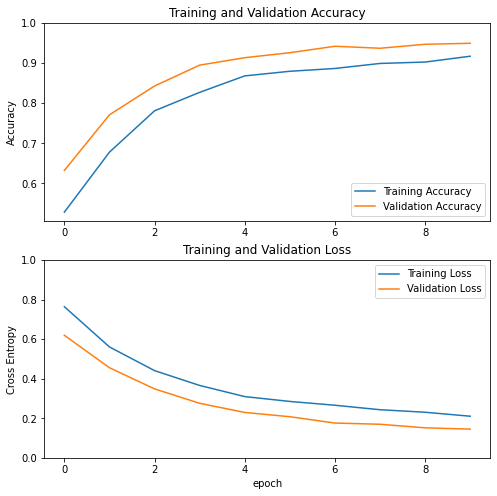

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [29]:
base_model.trainable = True

In [30]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
# TODO
# TODO: Your code goes here


Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [31]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [33]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [34]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


 1/63 [..............................] - ETA: 4:59 - loss: 0.3153 - accuracy: 0.8125

 2/63 [..............................] - ETA: 19s - loss: 0.2991 - accuracy: 0.8438 

 3/63 [>.............................] - ETA: 19s - loss: 0.2756 - accuracy: 0.8646

 4/63 [>.............................] - ETA: 19s - loss: 0.2639 - accuracy: 0.8750

 5/63 [=>............................] - ETA: 18s - loss: 0.2605 - accuracy: 0.8788

 6/63 [=>............................] - ETA: 18s - loss: 0.2641 - accuracy: 0.8790

 7/63 [==>...........................] - ETA: 18s - loss: 0.2630 - accuracy: 0.8803

 8/63 [==>...........................] - ETA: 18s - loss: 0.2596 - accuracy: 0.8831

 9/63 [===>..........................] - ETA: 17s - loss: 0.2553 - accuracy: 0.8864

10/63 [===>..........................] - ETA: 17s - loss: 0.2503 - accuracy: 0.8900

11/63 [====>.........................] - ETA: 17s - loss: 0.2454 - accuracy: 0.8933

12/63 [====>.........................] - ETA: 16s - loss: 0.2407 - accuracy: 0.8963

13/63 [=====>........................] - ETA: 16s - loss: 0.2368 - accuracy: 0.8987

14/63 [=====>........................] - ETA: 15s - loss: 0.2331 - accuracy: 0.9010

15/63 [======>.......................] - ETA: 15s - loss: 0.2305 - accuracy: 0.9028

16/63 [======>.......................] - ETA: 15s - loss: 0.2283 - accuracy: 0.9042

17/63 [=======>......................] - ETA: 15s - loss: 0.2263 - accuracy: 0.9056

18/63 [=======>......................] - ETA: 14s - loss: 0.2243 - accuracy: 0.9069

19/63 [========>.....................] - ETA: 14s - loss: 0.2225 - accuracy: 0.9081

20/63 [========>.....................] - ETA: 14s - loss: 0.2208 - accuracy: 0.9091

21/63 [=========>....................] - ETA: 13s - loss: 0.2192 - accuracy: 0.9101

22/63 [=========>....................] - ETA: 13s - loss: 0.2176 - accuracy: 0.9109

23/63 [=========>....................] - ETA: 13s - loss: 0.2160 - accuracy: 0.9118

24/63 [==========>...................] - ETA: 12s - loss: 0.2142 - accuracy: 0.9127

25/63 [==========>...................] - ETA: 12s - loss: 0.2126 - accuracy: 0.9137

26/63 [===========>..................] - ETA: 12s - loss: 0.2110 - accuracy: 0.9145

27/63 [===========>..................] - ETA: 11s - loss: 0.2094 - accuracy: 0.9154

28/63 [============>.................] - ETA: 11s - loss: 0.2080 - accuracy: 0.9162

29/63 [============>.................] - ETA: 11s - loss: 0.2068 - accuracy: 0.9168

30/63 [=============>................] - ETA: 10s - loss: 0.2056 - accuracy: 0.9174

31/63 [=============>................] - ETA: 10s - loss: 0.2045 - accuracy: 0.9179

32/63 [==============>...............] - ETA: 10s - loss: 0.2034 - accuracy: 0.9184

33/63 [==============>...............] - ETA: 9s - loss: 0.2024 - accuracy: 0.9189 

34/63 [===============>..............] - ETA: 9s - loss: 0.2014 - accuracy: 0.9194

35/63 [===============>..............] - ETA: 9s - loss: 0.2003 - accuracy: 0.9199

36/63 [================>.............] - ETA: 8s - loss: 0.1993 - accuracy: 0.9204

37/63 [================>.............] - ETA: 8s - loss: 0.1983 - accuracy: 0.9209

38/63 [=================>............] - ETA: 8s - loss: 0.1973 - accuracy: 0.9214

39/63 [=================>............] - ETA: 7s - loss: 0.1963 - accuracy: 0.9218

40/63 [==================>...........] - ETA: 7s - loss: 0.1954 - accuracy: 0.9222

41/63 [==================>...........] - ETA: 7s - loss: 0.1946 - accuracy: 0.9226

42/63 [===================>..........] - ETA: 6s - loss: 0.1937 - accuracy: 0.9230

43/63 [===================>..........] - ETA: 6s - loss: 0.1929 - accuracy: 0.9234

44/63 [===================>..........] - ETA: 6s - loss: 0.1920 - accuracy: 0.9238

45/63 [====================>.........] - ETA: 5s - loss: 0.1912 - accuracy: 0.9242

46/63 [====================>.........] - ETA: 5s - loss: 0.1905 - accuracy: 0.9245

47/63 [=====================>........] - ETA: 5s - loss: 0.1898 - accuracy: 0.9248

48/63 [=====================>........] - ETA: 4s - loss: 0.1891 - accuracy: 0.9252

49/63 [======================>.......] - ETA: 4s - loss: 0.1885 - accuracy: 0.9254

50/63 [======================>.......] - ETA: 4s - loss: 0.1879 - accuracy: 0.9257

51/63 [=======================>......] - ETA: 3s - loss: 0.1873 - accuracy: 0.9260

52/63 [=======================>......] - ETA: 3s - loss: 0.1867 - accuracy: 0.9263

53/63 [========================>.....] - ETA: 3s - loss: 0.1861 - accuracy: 0.9266

54/63 [========================>.....] - ETA: 2s - loss: 0.1855 - accuracy: 0.9268

55/63 [=========================>....] - ETA: 2s - loss: 0.1850 - accuracy: 0.9270

56/63 [=========================>....] - ETA: 2s - loss: 0.1846 - accuracy: 0.9272

57/63 [==========================>...] - ETA: 1s - loss: 0.1841 - accuracy: 0.9275

58/63 [==========================>...] - ETA: 1s - loss: 0.1837 - accuracy: 0.9277

59/63 [===========================>..] - ETA: 1s - loss: 0.1832 - accuracy: 0.9279

60/63 [===========================>..] - ETA: 0s - loss: 0.1827 - accuracy: 0.9281

61/63 [============================>.] - ETA: 0s - loss: 0.1823 - accuracy: 0.9283

62/63 [============================>.] - ETA: 0s - loss: 0.1818 - accuracy: 0.9285

63/63 [==============================] - ETA: 0s - loss: 0.1814 - accuracy: 0.9287

63/63 [==============================] - 31s 426ms/step - loss: 0.1810 - accuracy: 0.9288 - val_loss: 0.0674 - val_accuracy: 0.9752


Epoch 11/20


 1/63 [..............................] - ETA: 41s - loss: 0.0734 - accuracy: 0.9688

 2/63 [..............................] - ETA: 20s - loss: 0.1096 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 19s - loss: 0.1215 - accuracy: 0.9340

 4/63 [>.............................] - ETA: 19s - loss: 0.1237 - accuracy: 0.9349

 5/63 [=>............................] - ETA: 19s - loss: 0.1245 - accuracy: 0.9367

 6/63 [=>............................] - ETA: 19s - loss: 0.1272 - accuracy: 0.9359

 7/63 [==>...........................] - ETA: 18s - loss: 0.1266 - accuracy: 0.9368

 8/63 [==>...........................] - ETA: 18s - loss: 0.1259 - accuracy: 0.9374

 9/63 [===>..........................] - ETA: 17s - loss: 0.1245 - accuracy: 0.9382

10/63 [===>..........................] - ETA: 17s - loss: 0.1231 - accuracy: 0.9384

11/63 [====>.........................] - ETA: 17s - loss: 0.1220 - accuracy: 0.9388

12/63 [====>.........................] - ETA: 16s - loss: 0.1216 - accuracy: 0.9392

13/63 [=====>........................] - ETA: 16s - loss: 0.1209 - accuracy: 0.9398

14/63 [=====>........................] - ETA: 16s - loss: 0.1206 - accuracy: 0.9402

15/63 [======>.......................] - ETA: 15s - loss: 0.1207 - accuracy: 0.9408

16/63 [======>.......................] - ETA: 15s - loss: 0.1212 - accuracy: 0.9410

17/63 [=======>......................] - ETA: 15s - loss: 0.1212 - accuracy: 0.9415

18/63 [=======>......................] - ETA: 14s - loss: 0.1210 - accuracy: 0.9420

19/63 [========>.....................] - ETA: 14s - loss: 0.1208 - accuracy: 0.9426

20/63 [========>.....................] - ETA: 14s - loss: 0.1204 - accuracy: 0.9430

21/63 [=========>....................] - ETA: 13s - loss: 0.1200 - accuracy: 0.9435

22/63 [=========>....................] - ETA: 13s - loss: 0.1197 - accuracy: 0.9440

23/63 [=========>....................] - ETA: 13s - loss: 0.1198 - accuracy: 0.9441

24/63 [==========>...................] - ETA: 12s - loss: 0.1199 - accuracy: 0.9443

25/63 [==========>...................] - ETA: 12s - loss: 0.1199 - accuracy: 0.9445

26/63 [===========>..................] - ETA: 12s - loss: 0.1199 - accuracy: 0.9447

27/63 [===========>..................] - ETA: 11s - loss: 0.1202 - accuracy: 0.9449

28/63 [============>.................] - ETA: 11s - loss: 0.1204 - accuracy: 0.9451

29/63 [============>.................] - ETA: 11s - loss: 0.1207 - accuracy: 0.9452

30/63 [=============>................] - ETA: 10s - loss: 0.1210 - accuracy: 0.9453

31/63 [=============>................] - ETA: 10s - loss: 0.1212 - accuracy: 0.9454

32/63 [==============>...............] - ETA: 10s - loss: 0.1213 - accuracy: 0.9455

33/63 [==============>...............] - ETA: 9s - loss: 0.1217 - accuracy: 0.9455 

34/63 [===============>..............] - ETA: 9s - loss: 0.1221 - accuracy: 0.9455

35/63 [===============>..............] - ETA: 9s - loss: 0.1224 - accuracy: 0.9456

36/63 [================>.............] - ETA: 8s - loss: 0.1226 - accuracy: 0.9457

37/63 [================>.............] - ETA: 8s - loss: 0.1228 - accuracy: 0.9457

38/63 [=================>............] - ETA: 8s - loss: 0.1230 - accuracy: 0.9458

39/63 [=================>............] - ETA: 7s - loss: 0.1231 - accuracy: 0.9459

40/63 [==================>...........] - ETA: 7s - loss: 0.1231 - accuracy: 0.9460

41/63 [==================>...........] - ETA: 7s - loss: 0.1232 - accuracy: 0.9461

42/63 [===================>..........] - ETA: 6s - loss: 0.1232 - accuracy: 0.9462

43/63 [===================>..........] - ETA: 6s - loss: 0.1232 - accuracy: 0.9464

44/63 [===================>..........] - ETA: 6s - loss: 0.1231 - accuracy: 0.9465

45/63 [====================>.........] - ETA: 5s - loss: 0.1230 - accuracy: 0.9467

46/63 [====================>.........] - ETA: 5s - loss: 0.1230 - accuracy: 0.9468

47/63 [=====================>........] - ETA: 5s - loss: 0.1229 - accuracy: 0.9470

48/63 [=====================>........] - ETA: 4s - loss: 0.1229 - accuracy: 0.9472

49/63 [======================>.......] - ETA: 4s - loss: 0.1229 - accuracy: 0.9473

50/63 [======================>.......] - ETA: 4s - loss: 0.1229 - accuracy: 0.9474

51/63 [=======================>......] - ETA: 3s - loss: 0.1228 - accuracy: 0.9476

52/63 [=======================>......] - ETA: 3s - loss: 0.1228 - accuracy: 0.9477

53/63 [========================>.....] - ETA: 3s - loss: 0.1228 - accuracy: 0.9478

54/63 [========================>.....] - ETA: 2s - loss: 0.1227 - accuracy: 0.9480

55/63 [=========================>....] - ETA: 2s - loss: 0.1226 - accuracy: 0.9482

56/63 [=========================>....] - ETA: 2s - loss: 0.1225 - accuracy: 0.9483

57/63 [==========================>...] - ETA: 1s - loss: 0.1225 - accuracy: 0.9485

58/63 [==========================>...] - ETA: 1s - loss: 0.1224 - accuracy: 0.9486

59/63 [===========================>..] - ETA: 1s - loss: 0.1223 - accuracy: 0.9488

60/63 [===========================>..] - ETA: 0s - loss: 0.1222 - accuracy: 0.9489

61/63 [============================>.] - ETA: 0s - loss: 0.1222 - accuracy: 0.9490

62/63 [============================>.] - ETA: 0s - loss: 0.1221 - accuracy: 0.9492

63/63 [==============================] - ETA: 0s - loss: 0.1221 - accuracy: 0.9493

63/63 [==============================] - 26s 406ms/step - loss: 0.1221 - accuracy: 0.9494 - val_loss: 0.0592 - val_accuracy: 0.9827


Epoch 12/20


 1/63 [..............................] - ETA: 38s - loss: 0.1157 - accuracy: 0.9375

 2/63 [..............................] - ETA: 20s - loss: 0.1001 - accuracy: 0.9531

 3/63 [>.............................] - ETA: 19s - loss: 0.0924 - accuracy: 0.9583

 4/63 [>.............................] - ETA: 18s - loss: 0.0987 - accuracy: 0.9551

 5/63 [=>............................] - ETA: 18s - loss: 0.0993 - accuracy: 0.9553

 6/63 [=>............................] - ETA: 17s - loss: 0.1072 - accuracy: 0.9532

 7/63 [==>...........................] - ETA: 17s - loss: 0.1124 - accuracy: 0.9516

 8/63 [==>...........................] - ETA: 17s - loss: 0.1152 - accuracy: 0.9513

 9/63 [===>..........................] - ETA: 16s - loss: 0.1167 - accuracy: 0.9513

10/63 [===>..........................] - ETA: 16s - loss: 0.1170 - accuracy: 0.9518

11/63 [====>.........................] - ETA: 16s - loss: 0.1168 - accuracy: 0.9523

12/63 [====>.........................] - ETA: 16s - loss: 0.1166 - accuracy: 0.9528

13/63 [=====>........................] - ETA: 15s - loss: 0.1162 - accuracy: 0.9531

14/63 [=====>........................] - ETA: 15s - loss: 0.1158 - accuracy: 0.9533

15/63 [======>.......................] - ETA: 15s - loss: 0.1154 - accuracy: 0.9533

16/63 [======>.......................] - ETA: 14s - loss: 0.1148 - accuracy: 0.9534

17/63 [=======>......................] - ETA: 14s - loss: 0.1142 - accuracy: 0.9535

18/63 [=======>......................] - ETA: 14s - loss: 0.1137 - accuracy: 0.9536

19/63 [========>.....................] - ETA: 13s - loss: 0.1130 - accuracy: 0.9537

20/63 [========>.....................] - ETA: 13s - loss: 0.1124 - accuracy: 0.9538

21/63 [=========>....................] - ETA: 13s - loss: 0.1119 - accuracy: 0.9539

22/63 [=========>....................] - ETA: 13s - loss: 0.1114 - accuracy: 0.9540

23/63 [=========>....................] - ETA: 12s - loss: 0.1111 - accuracy: 0.9540

24/63 [==========>...................] - ETA: 12s - loss: 0.1108 - accuracy: 0.9541

25/63 [==========>...................] - ETA: 12s - loss: 0.1104 - accuracy: 0.9542

26/63 [===========>..................] - ETA: 11s - loss: 0.1101 - accuracy: 0.9544

27/63 [===========>..................] - ETA: 11s - loss: 0.1102 - accuracy: 0.9543

28/63 [============>.................] - ETA: 11s - loss: 0.1103 - accuracy: 0.9543

29/63 [============>.................] - ETA: 10s - loss: 0.1104 - accuracy: 0.9543

30/63 [=============>................] - ETA: 10s - loss: 0.1107 - accuracy: 0.9542

31/63 [=============>................] - ETA: 10s - loss: 0.1110 - accuracy: 0.9541

32/63 [==============>...............] - ETA: 9s - loss: 0.1112 - accuracy: 0.9541 

33/63 [==============>...............] - ETA: 9s - loss: 0.1114 - accuracy: 0.9540

34/63 [===============>..............] - ETA: 9s - loss: 0.1116 - accuracy: 0.9540

35/63 [===============>..............] - ETA: 8s - loss: 0.1116 - accuracy: 0.9539

36/63 [================>.............] - ETA: 8s - loss: 0.1117 - accuracy: 0.9539

37/63 [================>.............] - ETA: 8s - loss: 0.1117 - accuracy: 0.9539

38/63 [=================>............] - ETA: 7s - loss: 0.1117 - accuracy: 0.9539

39/63 [=================>............] - ETA: 7s - loss: 0.1117 - accuracy: 0.9538

40/63 [==================>...........] - ETA: 7s - loss: 0.1117 - accuracy: 0.9538

41/63 [==================>...........] - ETA: 6s - loss: 0.1117 - accuracy: 0.9537

42/63 [===================>..........] - ETA: 6s - loss: 0.1117 - accuracy: 0.9536

43/63 [===================>..........] - ETA: 6s - loss: 0.1117 - accuracy: 0.9536

44/63 [===================>..........] - ETA: 6s - loss: 0.1116 - accuracy: 0.9536

45/63 [====================>.........] - ETA: 5s - loss: 0.1116 - accuracy: 0.9535

46/63 [====================>.........] - ETA: 5s - loss: 0.1116 - accuracy: 0.9535

47/63 [=====================>........] - ETA: 5s - loss: 0.1115 - accuracy: 0.9535

48/63 [=====================>........] - ETA: 4s - loss: 0.1114 - accuracy: 0.9535

49/63 [======================>.......] - ETA: 4s - loss: 0.1114 - accuracy: 0.9535

50/63 [======================>.......] - ETA: 4s - loss: 0.1113 - accuracy: 0.9534

51/63 [=======================>......] - ETA: 3s - loss: 0.1113 - accuracy: 0.9534

52/63 [=======================>......] - ETA: 3s - loss: 0.1113 - accuracy: 0.9534

53/63 [========================>.....] - ETA: 3s - loss: 0.1113 - accuracy: 0.9533

54/63 [========================>.....] - ETA: 2s - loss: 0.1113 - accuracy: 0.9533

55/63 [=========================>....] - ETA: 2s - loss: 0.1113 - accuracy: 0.9533

56/63 [=========================>....] - ETA: 2s - loss: 0.1113 - accuracy: 0.9532

57/63 [==========================>...] - ETA: 1s - loss: 0.1113 - accuracy: 0.9532

58/63 [==========================>...] - ETA: 1s - loss: 0.1113 - accuracy: 0.9532

59/63 [===========================>..] - ETA: 1s - loss: 0.1113 - accuracy: 0.9531

60/63 [===========================>..] - ETA: 0s - loss: 0.1113 - accuracy: 0.9531

61/63 [============================>.] - ETA: 0s - loss: 0.1114 - accuracy: 0.9531

62/63 [============================>.] - ETA: 0s - loss: 0.1115 - accuracy: 0.9530

63/63 [==============================] - ETA: 0s - loss: 0.1115 - accuracy: 0.9530

63/63 [==============================] - 26s 402ms/step - loss: 0.1116 - accuracy: 0.9529 - val_loss: 0.0732 - val_accuracy: 0.9666


Epoch 13/20


 1/63 [..............................] - ETA: 38s - loss: 0.2541 - accuracy: 0.9375

 2/63 [..............................] - ETA: 19s - loss: 0.2249 - accuracy: 0.9297

 3/63 [>.............................] - ETA: 19s - loss: 0.1972 - accuracy: 0.9323

 4/63 [>.............................] - ETA: 19s - loss: 0.1781 - accuracy: 0.9375

 5/63 [=>............................] - ETA: 18s - loss: 0.1638 - accuracy: 0.9413

 6/63 [=>............................] - ETA: 18s - loss: 0.1537 - accuracy: 0.9432

 7/63 [==>...........................] - ETA: 18s - loss: 0.1461 - accuracy: 0.9450

 8/63 [==>...........................] - ETA: 17s - loss: 0.1397 - accuracy: 0.9465

 9/63 [===>..........................] - ETA: 17s - loss: 0.1339 - accuracy: 0.9482

10/63 [===>..........................] - ETA: 17s - loss: 0.1288 - accuracy: 0.9499

11/63 [====>.........................] - ETA: 16s - loss: 0.1250 - accuracy: 0.9511

12/63 [====>.........................] - ETA: 16s - loss: 0.1216 - accuracy: 0.9522

13/63 [=====>........................] - ETA: 16s - loss: 0.1183 - accuracy: 0.9532

14/63 [=====>........................] - ETA: 15s - loss: 0.1157 - accuracy: 0.9540

15/63 [======>.......................] - ETA: 15s - loss: 0.1131 - accuracy: 0.9549

16/63 [======>.......................] - ETA: 15s - loss: 0.1108 - accuracy: 0.9557

17/63 [=======>......................] - ETA: 14s - loss: 0.1084 - accuracy: 0.9566

18/63 [=======>......................] - ETA: 14s - loss: 0.1063 - accuracy: 0.9574

19/63 [========>.....................] - ETA: 14s - loss: 0.1045 - accuracy: 0.9579

20/63 [========>.....................] - ETA: 13s - loss: 0.1029 - accuracy: 0.9583

21/63 [=========>....................] - ETA: 13s - loss: 0.1016 - accuracy: 0.9585

22/63 [=========>....................] - ETA: 13s - loss: 0.1008 - accuracy: 0.9585

23/63 [=========>....................] - ETA: 12s - loss: 0.1000 - accuracy: 0.9585

24/63 [==========>...................] - ETA: 12s - loss: 0.0994 - accuracy: 0.9585

25/63 [==========>...................] - ETA: 12s - loss: 0.0989 - accuracy: 0.9584

26/63 [===========>..................] - ETA: 11s - loss: 0.0984 - accuracy: 0.9584

27/63 [===========>..................] - ETA: 11s - loss: 0.0981 - accuracy: 0.9583

28/63 [============>.................] - ETA: 11s - loss: 0.0977 - accuracy: 0.9583

29/63 [============>.................] - ETA: 10s - loss: 0.0974 - accuracy: 0.9582

30/63 [=============>................] - ETA: 10s - loss: 0.0971 - accuracy: 0.9581

31/63 [=============>................] - ETA: 10s - loss: 0.0969 - accuracy: 0.9580

32/63 [==============>...............] - ETA: 9s - loss: 0.0967 - accuracy: 0.9579 

33/63 [==============>...............] - ETA: 9s - loss: 0.0965 - accuracy: 0.9578

34/63 [===============>..............] - ETA: 9s - loss: 0.0963 - accuracy: 0.9578

35/63 [===============>..............] - ETA: 8s - loss: 0.0961 - accuracy: 0.9578

36/63 [================>.............] - ETA: 8s - loss: 0.0959 - accuracy: 0.9578

37/63 [================>.............] - ETA: 8s - loss: 0.0958 - accuracy: 0.9578

38/63 [=================>............] - ETA: 8s - loss: 0.0956 - accuracy: 0.9578

39/63 [=================>............] - ETA: 7s - loss: 0.0955 - accuracy: 0.9578

40/63 [==================>...........] - ETA: 7s - loss: 0.0952 - accuracy: 0.9579

41/63 [==================>...........] - ETA: 7s - loss: 0.0950 - accuracy: 0.9579

42/63 [===================>..........] - ETA: 6s - loss: 0.0950 - accuracy: 0.9580

43/63 [===================>..........] - ETA: 6s - loss: 0.0949 - accuracy: 0.9580

44/63 [===================>..........] - ETA: 6s - loss: 0.0947 - accuracy: 0.9581

45/63 [====================>.........] - ETA: 5s - loss: 0.0946 - accuracy: 0.9581

46/63 [====================>.........] - ETA: 5s - loss: 0.0946 - accuracy: 0.9581

47/63 [=====================>........] - ETA: 5s - loss: 0.0947 - accuracy: 0.9581

48/63 [=====================>........] - ETA: 4s - loss: 0.0947 - accuracy: 0.9581

49/63 [======================>.......] - ETA: 4s - loss: 0.0948 - accuracy: 0.9582

50/63 [======================>.......] - ETA: 4s - loss: 0.0949 - accuracy: 0.9582

51/63 [=======================>......] - ETA: 3s - loss: 0.0949 - accuracy: 0.9582

52/63 [=======================>......] - ETA: 3s - loss: 0.0949 - accuracy: 0.9582

53/63 [========================>.....] - ETA: 3s - loss: 0.0950 - accuracy: 0.9583

54/63 [========================>.....] - ETA: 2s - loss: 0.0950 - accuracy: 0.9583

55/63 [=========================>....] - ETA: 2s - loss: 0.0950 - accuracy: 0.9583

56/63 [=========================>....] - ETA: 2s - loss: 0.0950 - accuracy: 0.9584

57/63 [==========================>...] - ETA: 1s - loss: 0.0950 - accuracy: 0.9584

58/63 [==========================>...] - ETA: 1s - loss: 0.0950 - accuracy: 0.9584

59/63 [===========================>..] - ETA: 1s - loss: 0.0950 - accuracy: 0.9585

60/63 [===========================>..] - ETA: 0s - loss: 0.0950 - accuracy: 0.9585

61/63 [============================>.] - ETA: 0s - loss: 0.0950 - accuracy: 0.9585

62/63 [============================>.] - ETA: 0s - loss: 0.0950 - accuracy: 0.9586

63/63 [==============================] - ETA: 0s - loss: 0.0950 - accuracy: 0.9586

63/63 [==============================] - 26s 402ms/step - loss: 0.0950 - accuracy: 0.9586 - val_loss: 0.0467 - val_accuracy: 0.9790


Epoch 14/20


 1/63 [..............................] - ETA: 38s - loss: 0.2408 - accuracy: 0.8750

 2/63 [..............................] - ETA: 18s - loss: 0.2104 - accuracy: 0.8906

 3/63 [>.............................] - ETA: 18s - loss: 0.2066 - accuracy: 0.8993

 4/63 [>.............................] - ETA: 18s - loss: 0.1951 - accuracy: 0.9089

 5/63 [=>............................] - ETA: 17s - loss: 0.1850 - accuracy: 0.9158

 6/63 [=>............................] - ETA: 17s - loss: 0.1774 - accuracy: 0.9194

 7/63 [==>...........................] - ETA: 17s - loss: 0.1693 - accuracy: 0.9233

 8/63 [==>...........................] - ETA: 16s - loss: 0.1619 - accuracy: 0.9265

 9/63 [===>..........................] - ETA: 16s - loss: 0.1566 - accuracy: 0.9289

10/63 [===>..........................] - ETA: 16s - loss: 0.1520 - accuracy: 0.9310

11/63 [====>.........................] - ETA: 16s - loss: 0.1480 - accuracy: 0.9329

12/63 [====>.........................] - ETA: 15s - loss: 0.1440 - accuracy: 0.9348

13/63 [=====>........................] - ETA: 15s - loss: 0.1403 - accuracy: 0.9367

14/63 [=====>........................] - ETA: 15s - loss: 0.1371 - accuracy: 0.9383

15/63 [======>.......................] - ETA: 14s - loss: 0.1345 - accuracy: 0.9397

16/63 [======>.......................] - ETA: 14s - loss: 0.1320 - accuracy: 0.9410

17/63 [=======>......................] - ETA: 14s - loss: 0.1302 - accuracy: 0.9422

18/63 [=======>......................] - ETA: 14s - loss: 0.1285 - accuracy: 0.9433

19/63 [========>.....................] - ETA: 13s - loss: 0.1271 - accuracy: 0.9442

20/63 [========>.....................] - ETA: 13s - loss: 0.1258 - accuracy: 0.9450

21/63 [=========>....................] - ETA: 13s - loss: 0.1244 - accuracy: 0.9459

22/63 [=========>....................] - ETA: 12s - loss: 0.1230 - accuracy: 0.9467

23/63 [=========>....................] - ETA: 12s - loss: 0.1222 - accuracy: 0.9473

24/63 [==========>...................] - ETA: 12s - loss: 0.1216 - accuracy: 0.9477

25/63 [==========>...................] - ETA: 11s - loss: 0.1210 - accuracy: 0.9482

26/63 [===========>..................] - ETA: 11s - loss: 0.1204 - accuracy: 0.9485

27/63 [===========>..................] - ETA: 11s - loss: 0.1200 - accuracy: 0.9488

28/63 [============>.................] - ETA: 10s - loss: 0.1195 - accuracy: 0.9491

29/63 [============>.................] - ETA: 10s - loss: 0.1190 - accuracy: 0.9494

30/63 [=============>................] - ETA: 10s - loss: 0.1184 - accuracy: 0.9497

31/63 [=============>................] - ETA: 9s - loss: 0.1180 - accuracy: 0.9499 

32/63 [==============>...............] - ETA: 9s - loss: 0.1175 - accuracy: 0.9502

33/63 [==============>...............] - ETA: 9s - loss: 0.1170 - accuracy: 0.9504

34/63 [===============>..............] - ETA: 9s - loss: 0.1167 - accuracy: 0.9506

35/63 [===============>..............] - ETA: 8s - loss: 0.1163 - accuracy: 0.9508

36/63 [================>.............] - ETA: 8s - loss: 0.1160 - accuracy: 0.9510

37/63 [================>.............] - ETA: 8s - loss: 0.1157 - accuracy: 0.9512

38/63 [=================>............] - ETA: 7s - loss: 0.1153 - accuracy: 0.9514

39/63 [=================>............] - ETA: 7s - loss: 0.1150 - accuracy: 0.9516

40/63 [==================>...........] - ETA: 7s - loss: 0.1147 - accuracy: 0.9518

41/63 [==================>...........] - ETA: 6s - loss: 0.1144 - accuracy: 0.9520

42/63 [===================>..........] - ETA: 6s - loss: 0.1141 - accuracy: 0.9521

43/63 [===================>..........] - ETA: 6s - loss: 0.1138 - accuracy: 0.9523

44/63 [===================>..........] - ETA: 5s - loss: 0.1135 - accuracy: 0.9525

45/63 [====================>.........] - ETA: 5s - loss: 0.1132 - accuracy: 0.9527

46/63 [====================>.........] - ETA: 5s - loss: 0.1129 - accuracy: 0.9529

47/63 [=====================>........] - ETA: 5s - loss: 0.1125 - accuracy: 0.9531

48/63 [=====================>........] - ETA: 4s - loss: 0.1121 - accuracy: 0.9533

49/63 [======================>.......] - ETA: 4s - loss: 0.1118 - accuracy: 0.9535

50/63 [======================>.......] - ETA: 4s - loss: 0.1114 - accuracy: 0.9537

51/63 [=======================>......] - ETA: 3s - loss: 0.1111 - accuracy: 0.9539

52/63 [=======================>......] - ETA: 3s - loss: 0.1107 - accuracy: 0.9540

53/63 [========================>.....] - ETA: 3s - loss: 0.1104 - accuracy: 0.9542

54/63 [========================>.....] - ETA: 2s - loss: 0.1100 - accuracy: 0.9544

55/63 [=========================>....] - ETA: 2s - loss: 0.1097 - accuracy: 0.9545

56/63 [=========================>....] - ETA: 2s - loss: 0.1095 - accuracy: 0.9547

57/63 [==========================>...] - ETA: 1s - loss: 0.1092 - accuracy: 0.9548

58/63 [==========================>...] - ETA: 1s - loss: 0.1089 - accuracy: 0.9549

59/63 [===========================>..] - ETA: 1s - loss: 0.1086 - accuracy: 0.9551

60/63 [===========================>..] - ETA: 0s - loss: 0.1084 - accuracy: 0.9552

61/63 [============================>.] - ETA: 0s - loss: 0.1082 - accuracy: 0.9553

62/63 [============================>.] - ETA: 0s - loss: 0.1080 - accuracy: 0.9554

63/63 [==============================] - ETA: 0s - loss: 0.1077 - accuracy: 0.9555

63/63 [==============================] - 25s 396ms/step - loss: 0.1075 - accuracy: 0.9556 - val_loss: 0.0487 - val_accuracy: 0.9814


Epoch 15/20


 1/63 [..............................] - ETA: 38s - loss: 0.0143 - accuracy: 1.0000

 2/63 [..............................] - ETA: 19s - loss: 0.0281 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 18s - loss: 0.0327 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 18s - loss: 0.0417 - accuracy: 0.9941

 5/63 [=>............................] - ETA: 18s - loss: 0.0449 - accuracy: 0.9916

 6/63 [=>............................] - ETA: 17s - loss: 0.0474 - accuracy: 0.9886

 7/63 [==>...........................] - ETA: 17s - loss: 0.0487 - accuracy: 0.9864

 8/63 [==>...........................] - ETA: 17s - loss: 0.0493 - accuracy: 0.9852

 9/63 [===>..........................] - ETA: 16s - loss: 0.0495 - accuracy: 0.9845

10/63 [===>..........................] - ETA: 16s - loss: 0.0504 - accuracy: 0.9839

11/63 [====>.........................] - ETA: 16s - loss: 0.0517 - accuracy: 0.9830

12/63 [====>.........................] - ETA: 15s - loss: 0.0531 - accuracy: 0.9821

13/63 [=====>........................] - ETA: 15s - loss: 0.0542 - accuracy: 0.9814

14/63 [=====>........................] - ETA: 15s - loss: 0.0550 - accuracy: 0.9807

15/63 [======>.......................] - ETA: 14s - loss: 0.0554 - accuracy: 0.9801

16/63 [======>.......................] - ETA: 14s - loss: 0.0557 - accuracy: 0.9798

17/63 [=======>......................] - ETA: 14s - loss: 0.0558 - accuracy: 0.9796

18/63 [=======>......................] - ETA: 14s - loss: 0.0557 - accuracy: 0.9795

19/63 [========>.....................] - ETA: 13s - loss: 0.0559 - accuracy: 0.9793

20/63 [========>.....................] - ETA: 13s - loss: 0.0563 - accuracy: 0.9792

21/63 [=========>....................] - ETA: 13s - loss: 0.0566 - accuracy: 0.9790

22/63 [=========>....................] - ETA: 12s - loss: 0.0568 - accuracy: 0.9790

23/63 [=========>....................] - ETA: 12s - loss: 0.0570 - accuracy: 0.9788

24/63 [==========>...................] - ETA: 12s - loss: 0.0574 - accuracy: 0.9786

25/63 [==========>...................] - ETA: 11s - loss: 0.0577 - accuracy: 0.9784

26/63 [===========>..................] - ETA: 11s - loss: 0.0579 - accuracy: 0.9782

27/63 [===========>..................] - ETA: 11s - loss: 0.0581 - accuracy: 0.9781

28/63 [============>.................] - ETA: 11s - loss: 0.0582 - accuracy: 0.9780

29/63 [============>.................] - ETA: 10s - loss: 0.0583 - accuracy: 0.9780

30/63 [=============>................] - ETA: 10s - loss: 0.0584 - accuracy: 0.9779

31/63 [=============>................] - ETA: 10s - loss: 0.0585 - accuracy: 0.9778

32/63 [==============>...............] - ETA: 9s - loss: 0.0586 - accuracy: 0.9777 

33/63 [==============>...............] - ETA: 9s - loss: 0.0588 - accuracy: 0.9775

34/63 [===============>..............] - ETA: 9s - loss: 0.0591 - accuracy: 0.9773

35/63 [===============>..............] - ETA: 8s - loss: 0.0595 - accuracy: 0.9771

36/63 [================>.............] - ETA: 8s - loss: 0.0599 - accuracy: 0.9769

37/63 [================>.............] - ETA: 8s - loss: 0.0602 - accuracy: 0.9767

38/63 [=================>............] - ETA: 7s - loss: 0.0604 - accuracy: 0.9765

39/63 [=================>............] - ETA: 7s - loss: 0.0607 - accuracy: 0.9764

40/63 [==================>...........] - ETA: 7s - loss: 0.0609 - accuracy: 0.9762

41/63 [==================>...........] - ETA: 6s - loss: 0.0612 - accuracy: 0.9761

42/63 [===================>..........] - ETA: 6s - loss: 0.0614 - accuracy: 0.9760

43/63 [===================>..........] - ETA: 6s - loss: 0.0617 - accuracy: 0.9758

44/63 [===================>..........] - ETA: 5s - loss: 0.0620 - accuracy: 0.9757

45/63 [====================>.........] - ETA: 5s - loss: 0.0622 - accuracy: 0.9756

46/63 [====================>.........] - ETA: 5s - loss: 0.0624 - accuracy: 0.9755

47/63 [=====================>........] - ETA: 5s - loss: 0.0626 - accuracy: 0.9754

48/63 [=====================>........] - ETA: 4s - loss: 0.0629 - accuracy: 0.9753

49/63 [======================>.......] - ETA: 4s - loss: 0.0631 - accuracy: 0.9753

50/63 [======================>.......] - ETA: 4s - loss: 0.0633 - accuracy: 0.9752

51/63 [=======================>......] - ETA: 3s - loss: 0.0635 - accuracy: 0.9752

52/63 [=======================>......] - ETA: 3s - loss: 0.0637 - accuracy: 0.9751

53/63 [========================>.....] - ETA: 3s - loss: 0.0639 - accuracy: 0.9751

54/63 [========================>.....] - ETA: 2s - loss: 0.0642 - accuracy: 0.9750

55/63 [=========================>....] - ETA: 2s - loss: 0.0644 - accuracy: 0.9749

56/63 [=========================>....] - ETA: 2s - loss: 0.0647 - accuracy: 0.9748

57/63 [==========================>...] - ETA: 1s - loss: 0.0649 - accuracy: 0.9747

58/63 [==========================>...] - ETA: 1s - loss: 0.0651 - accuracy: 0.9746

59/63 [===========================>..] - ETA: 1s - loss: 0.0654 - accuracy: 0.9745

60/63 [===========================>..] - ETA: 0s - loss: 0.0656 - accuracy: 0.9744

61/63 [============================>.] - ETA: 0s - loss: 0.0658 - accuracy: 0.9744

62/63 [============================>.] - ETA: 0s - loss: 0.0660 - accuracy: 0.9743

63/63 [==============================] - ETA: 0s - loss: 0.0662 - accuracy: 0.9742

63/63 [==============================] - 25s 396ms/step - loss: 0.0664 - accuracy: 0.9741 - val_loss: 0.0435 - val_accuracy: 0.9827


Epoch 16/20


 1/63 [..............................] - ETA: 39s - loss: 0.0407 - accuracy: 1.0000

 2/63 [..............................] - ETA: 20s - loss: 0.0348 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 19s - loss: 0.0340 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 19s - loss: 0.0349 - accuracy: 0.9980

 5/63 [=>............................] - ETA: 18s - loss: 0.0373 - accuracy: 0.9947

 6/63 [=>............................] - ETA: 18s - loss: 0.0442 - accuracy: 0.9904

 7/63 [==>...........................] - ETA: 18s - loss: 0.0539 - accuracy: 0.9866

 8/63 [==>...........................] - ETA: 17s - loss: 0.0625 - accuracy: 0.9834

 9/63 [===>..........................] - ETA: 17s - loss: 0.0684 - accuracy: 0.9810

10/63 [===>..........................] - ETA: 16s - loss: 0.0723 - accuracy: 0.9792

11/63 [====>.........................] - ETA: 16s - loss: 0.0749 - accuracy: 0.9777

12/63 [====>.........................] - ETA: 16s - loss: 0.0771 - accuracy: 0.9765

13/63 [=====>........................] - ETA: 15s - loss: 0.0787 - accuracy: 0.9756

14/63 [=====>........................] - ETA: 15s - loss: 0.0799 - accuracy: 0.9748

15/63 [======>.......................] - ETA: 15s - loss: 0.0814 - accuracy: 0.9739

16/63 [======>.......................] - ETA: 14s - loss: 0.0826 - accuracy: 0.9732

17/63 [=======>......................] - ETA: 14s - loss: 0.0837 - accuracy: 0.9727

18/63 [=======>......................] - ETA: 14s - loss: 0.0845 - accuracy: 0.9722

19/63 [========>.....................] - ETA: 13s - loss: 0.0851 - accuracy: 0.9718

20/63 [========>.....................] - ETA: 13s - loss: 0.0856 - accuracy: 0.9714

21/63 [=========>....................] - ETA: 13s - loss: 0.0859 - accuracy: 0.9711

22/63 [=========>....................] - ETA: 13s - loss: 0.0861 - accuracy: 0.9708

23/63 [=========>....................] - ETA: 12s - loss: 0.0862 - accuracy: 0.9706

24/63 [==========>...................] - ETA: 12s - loss: 0.0863 - accuracy: 0.9703

25/63 [==========>...................] - ETA: 12s - loss: 0.0866 - accuracy: 0.9700

26/63 [===========>..................] - ETA: 11s - loss: 0.0868 - accuracy: 0.9697

27/63 [===========>..................] - ETA: 11s - loss: 0.0869 - accuracy: 0.9696

28/63 [============>.................] - ETA: 11s - loss: 0.0871 - accuracy: 0.9693

29/63 [============>.................] - ETA: 10s - loss: 0.0872 - accuracy: 0.9692

30/63 [=============>................] - ETA: 10s - loss: 0.0872 - accuracy: 0.9690

31/63 [=============>................] - ETA: 10s - loss: 0.0872 - accuracy: 0.9689

32/63 [==============>...............] - ETA: 9s - loss: 0.0873 - accuracy: 0.9688 

33/63 [==============>...............] - ETA: 9s - loss: 0.0873 - accuracy: 0.9687

34/63 [===============>..............] - ETA: 9s - loss: 0.0873 - accuracy: 0.9686

35/63 [===============>..............] - ETA: 8s - loss: 0.0873 - accuracy: 0.9686

36/63 [================>.............] - ETA: 8s - loss: 0.0873 - accuracy: 0.9685

37/63 [================>.............] - ETA: 8s - loss: 0.0873 - accuracy: 0.9685

38/63 [=================>............] - ETA: 7s - loss: 0.0873 - accuracy: 0.9685

39/63 [=================>............] - ETA: 7s - loss: 0.0872 - accuracy: 0.9685

40/63 [==================>...........] - ETA: 7s - loss: 0.0871 - accuracy: 0.9685

41/63 [==================>...........] - ETA: 6s - loss: 0.0870 - accuracy: 0.9685

42/63 [===================>..........] - ETA: 6s - loss: 0.0870 - accuracy: 0.9684

43/63 [===================>..........] - ETA: 6s - loss: 0.0870 - accuracy: 0.9684

44/63 [===================>..........] - ETA: 6s - loss: 0.0870 - accuracy: 0.9684

45/63 [====================>.........] - ETA: 5s - loss: 0.0870 - accuracy: 0.9684

46/63 [====================>.........] - ETA: 5s - loss: 0.0869 - accuracy: 0.9683

47/63 [=====================>........] - ETA: 5s - loss: 0.0868 - accuracy: 0.9683

48/63 [=====================>........] - ETA: 4s - loss: 0.0867 - accuracy: 0.9683

49/63 [======================>.......] - ETA: 4s - loss: 0.0866 - accuracy: 0.9683

50/63 [======================>.......] - ETA: 4s - loss: 0.0865 - accuracy: 0.9684

51/63 [=======================>......] - ETA: 3s - loss: 0.0864 - accuracy: 0.9684

52/63 [=======================>......] - ETA: 3s - loss: 0.0863 - accuracy: 0.9684

53/63 [========================>.....] - ETA: 3s - loss: 0.0863 - accuracy: 0.9684

54/63 [========================>.....] - ETA: 2s - loss: 0.0862 - accuracy: 0.9683

55/63 [=========================>....] - ETA: 2s - loss: 0.0862 - accuracy: 0.9683

56/63 [=========================>....] - ETA: 2s - loss: 0.0861 - accuracy: 0.9683

57/63 [==========================>...] - ETA: 1s - loss: 0.0860 - accuracy: 0.9683

58/63 [==========================>...] - ETA: 1s - loss: 0.0860 - accuracy: 0.9683

59/63 [===========================>..] - ETA: 1s - loss: 0.0860 - accuracy: 0.9682

60/63 [===========================>..] - ETA: 0s - loss: 0.0860 - accuracy: 0.9682

61/63 [============================>.] - ETA: 0s - loss: 0.0860 - accuracy: 0.9682

62/63 [============================>.] - ETA: 0s - loss: 0.0860 - accuracy: 0.9681

63/63 [==============================] - ETA: 0s - loss: 0.0860 - accuracy: 0.9681

63/63 [==============================] - 25s 398ms/step - loss: 0.0860 - accuracy: 0.9681 - val_loss: 0.0428 - val_accuracy: 0.9790


Epoch 17/20


 1/63 [..............................] - ETA: 38s - loss: 0.1388 - accuracy: 0.9688

 2/63 [..............................] - ETA: 19s - loss: 0.1099 - accuracy: 0.9766

 3/63 [>.............................] - ETA: 18s - loss: 0.0941 - accuracy: 0.9809

 4/63 [>.............................] - ETA: 18s - loss: 0.0855 - accuracy: 0.9798

 5/63 [=>............................] - ETA: 18s - loss: 0.0799 - accuracy: 0.9789

 6/63 [=>............................] - ETA: 17s - loss: 0.0761 - accuracy: 0.9789

 7/63 [==>...........................] - ETA: 17s - loss: 0.0728 - accuracy: 0.9794

 8/63 [==>...........................] - ETA: 17s - loss: 0.0701 - accuracy: 0.9800

 9/63 [===>..........................] - ETA: 16s - loss: 0.0695 - accuracy: 0.9803

10/63 [===>..........................] - ETA: 16s - loss: 0.0684 - accuracy: 0.9807

11/63 [====>.........................] - ETA: 16s - loss: 0.0681 - accuracy: 0.9804

12/63 [====>.........................] - ETA: 15s - loss: 0.0676 - accuracy: 0.9803

13/63 [=====>........................] - ETA: 15s - loss: 0.0671 - accuracy: 0.9803

14/63 [=====>........................] - ETA: 15s - loss: 0.0666 - accuracy: 0.9803

15/63 [======>.......................] - ETA: 15s - loss: 0.0662 - accuracy: 0.9804

16/63 [======>.......................] - ETA: 14s - loss: 0.0658 - accuracy: 0.9804

17/63 [=======>......................] - ETA: 14s - loss: 0.0654 - accuracy: 0.9803

18/63 [=======>......................] - ETA: 14s - loss: 0.0658 - accuracy: 0.9801

19/63 [========>.....................] - ETA: 13s - loss: 0.0660 - accuracy: 0.9799

20/63 [========>.....................] - ETA: 13s - loss: 0.0665 - accuracy: 0.9796

21/63 [=========>....................] - ETA: 13s - loss: 0.0668 - accuracy: 0.9794

22/63 [=========>....................] - ETA: 12s - loss: 0.0670 - accuracy: 0.9791

23/63 [=========>....................] - ETA: 12s - loss: 0.0675 - accuracy: 0.9789

24/63 [==========>...................] - ETA: 12s - loss: 0.0679 - accuracy: 0.9786

25/63 [==========>...................] - ETA: 11s - loss: 0.0684 - accuracy: 0.9783

26/63 [===========>..................] - ETA: 11s - loss: 0.0688 - accuracy: 0.9779

27/63 [===========>..................] - ETA: 11s - loss: 0.0691 - accuracy: 0.9776

28/63 [============>.................] - ETA: 10s - loss: 0.0695 - accuracy: 0.9773

29/63 [============>.................] - ETA: 10s - loss: 0.0699 - accuracy: 0.9769

30/63 [=============>................] - ETA: 10s - loss: 0.0702 - accuracy: 0.9766

31/63 [=============>................] - ETA: 10s - loss: 0.0705 - accuracy: 0.9763

32/63 [==============>...............] - ETA: 9s - loss: 0.0707 - accuracy: 0.9761 

33/63 [==============>...............] - ETA: 9s - loss: 0.0710 - accuracy: 0.9758

34/63 [===============>..............] - ETA: 9s - loss: 0.0712 - accuracy: 0.9756

35/63 [===============>..............] - ETA: 8s - loss: 0.0713 - accuracy: 0.9754

36/63 [================>.............] - ETA: 8s - loss: 0.0715 - accuracy: 0.9752

37/63 [================>.............] - ETA: 8s - loss: 0.0716 - accuracy: 0.9751

38/63 [=================>............] - ETA: 7s - loss: 0.0716 - accuracy: 0.9749

39/63 [=================>............] - ETA: 7s - loss: 0.0716 - accuracy: 0.9748

40/63 [==================>...........] - ETA: 7s - loss: 0.0716 - accuracy: 0.9748

41/63 [==================>...........] - ETA: 6s - loss: 0.0716 - accuracy: 0.9747

42/63 [===================>..........] - ETA: 6s - loss: 0.0716 - accuracy: 0.9746

43/63 [===================>..........] - ETA: 6s - loss: 0.0715 - accuracy: 0.9746

44/63 [===================>..........] - ETA: 5s - loss: 0.0715 - accuracy: 0.9745

45/63 [====================>.........] - ETA: 5s - loss: 0.0714 - accuracy: 0.9744

46/63 [====================>.........] - ETA: 5s - loss: 0.0713 - accuracy: 0.9744

47/63 [=====================>........] - ETA: 5s - loss: 0.0712 - accuracy: 0.9743

48/63 [=====================>........] - ETA: 4s - loss: 0.0712 - accuracy: 0.9743

49/63 [======================>.......] - ETA: 4s - loss: 0.0711 - accuracy: 0.9743

50/63 [======================>.......] - ETA: 4s - loss: 0.0710 - accuracy: 0.9742

51/63 [=======================>......] - ETA: 3s - loss: 0.0709 - accuracy: 0.9742

52/63 [=======================>......] - ETA: 3s - loss: 0.0709 - accuracy: 0.9742

53/63 [========================>.....] - ETA: 3s - loss: 0.0709 - accuracy: 0.9741

54/63 [========================>.....] - ETA: 2s - loss: 0.0709 - accuracy: 0.9741

55/63 [=========================>....] - ETA: 2s - loss: 0.0709 - accuracy: 0.9741

56/63 [=========================>....] - ETA: 2s - loss: 0.0709 - accuracy: 0.9741

57/63 [==========================>...] - ETA: 1s - loss: 0.0709 - accuracy: 0.9741

58/63 [==========================>...] - ETA: 1s - loss: 0.0709 - accuracy: 0.9741

59/63 [===========================>..] - ETA: 1s - loss: 0.0709 - accuracy: 0.9740

60/63 [===========================>..] - ETA: 0s - loss: 0.0709 - accuracy: 0.9740

61/63 [============================>.] - ETA: 0s - loss: 0.0709 - accuracy: 0.9740

62/63 [============================>.] - ETA: 0s - loss: 0.0709 - accuracy: 0.9740

63/63 [==============================] - ETA: 0s - loss: 0.0709 - accuracy: 0.9740

63/63 [==============================] - 25s 394ms/step - loss: 0.0709 - accuracy: 0.9740 - val_loss: 0.0662 - val_accuracy: 0.9691


Epoch 18/20


 1/63 [..............................] - ETA: 37s - loss: 0.0898 - accuracy: 0.9688

 2/63 [..............................] - ETA: 19s - loss: 0.0977 - accuracy: 0.9531

 3/63 [>.............................] - ETA: 19s - loss: 0.1198 - accuracy: 0.9479

 4/63 [>.............................] - ETA: 18s - loss: 0.1220 - accuracy: 0.9492

 5/63 [=>............................] - ETA: 18s - loss: 0.1200 - accuracy: 0.9506

 6/63 [=>............................] - ETA: 18s - loss: 0.1192 - accuracy: 0.9510

 7/63 [==>...........................] - ETA: 17s - loss: 0.1166 - accuracy: 0.9523

 8/63 [==>...........................] - ETA: 17s - loss: 0.1132 - accuracy: 0.9539

 9/63 [===>..........................] - ETA: 17s - loss: 0.1115 - accuracy: 0.9547

10/63 [===>..........................] - ETA: 16s - loss: 0.1103 - accuracy: 0.9555

11/63 [====>.........................] - ETA: 16s - loss: 0.1087 - accuracy: 0.9565

12/63 [====>.........................] - ETA: 16s - loss: 0.1069 - accuracy: 0.9575

13/63 [=====>........................] - ETA: 15s - loss: 0.1052 - accuracy: 0.9584

14/63 [=====>........................] - ETA: 15s - loss: 0.1036 - accuracy: 0.9589

15/63 [======>.......................] - ETA: 15s - loss: 0.1020 - accuracy: 0.9595

16/63 [======>.......................] - ETA: 14s - loss: 0.1006 - accuracy: 0.9600

17/63 [=======>......................] - ETA: 14s - loss: 0.0991 - accuracy: 0.9607

18/63 [=======>......................] - ETA: 14s - loss: 0.0978 - accuracy: 0.9612

19/63 [========>.....................] - ETA: 13s - loss: 0.0968 - accuracy: 0.9615

20/63 [========>.....................] - ETA: 13s - loss: 0.0958 - accuracy: 0.9618

21/63 [=========>....................] - ETA: 13s - loss: 0.0949 - accuracy: 0.9621

22/63 [=========>....................] - ETA: 12s - loss: 0.0939 - accuracy: 0.9624

23/63 [=========>....................] - ETA: 12s - loss: 0.0930 - accuracy: 0.9627

24/63 [==========>...................] - ETA: 12s - loss: 0.0922 - accuracy: 0.9630

25/63 [==========>...................] - ETA: 12s - loss: 0.0914 - accuracy: 0.9632

26/63 [===========>..................] - ETA: 11s - loss: 0.0907 - accuracy: 0.9634

27/63 [===========>..................] - ETA: 11s - loss: 0.0899 - accuracy: 0.9637

28/63 [============>.................] - ETA: 11s - loss: 0.0892 - accuracy: 0.9640

29/63 [============>.................] - ETA: 10s - loss: 0.0886 - accuracy: 0.9643

30/63 [=============>................] - ETA: 10s - loss: 0.0880 - accuracy: 0.9645

31/63 [=============>................] - ETA: 10s - loss: 0.0874 - accuracy: 0.9648

32/63 [==============>...............] - ETA: 9s - loss: 0.0869 - accuracy: 0.9650 

33/63 [==============>...............] - ETA: 9s - loss: 0.0864 - accuracy: 0.9652

34/63 [===============>..............] - ETA: 9s - loss: 0.0859 - accuracy: 0.9654

35/63 [===============>..............] - ETA: 8s - loss: 0.0854 - accuracy: 0.9656

36/63 [================>.............] - ETA: 8s - loss: 0.0850 - accuracy: 0.9657

37/63 [================>.............] - ETA: 8s - loss: 0.0846 - accuracy: 0.9659

38/63 [=================>............] - ETA: 7s - loss: 0.0842 - accuracy: 0.9660

39/63 [=================>............] - ETA: 7s - loss: 0.0837 - accuracy: 0.9662

40/63 [==================>...........] - ETA: 7s - loss: 0.0833 - accuracy: 0.9663

41/63 [==================>...........] - ETA: 6s - loss: 0.0829 - accuracy: 0.9665

42/63 [===================>..........] - ETA: 6s - loss: 0.0825 - accuracy: 0.9667

43/63 [===================>..........] - ETA: 6s - loss: 0.0823 - accuracy: 0.9668

44/63 [===================>..........] - ETA: 5s - loss: 0.0820 - accuracy: 0.9669

45/63 [====================>.........] - ETA: 5s - loss: 0.0818 - accuracy: 0.9670

46/63 [====================>.........] - ETA: 5s - loss: 0.0816 - accuracy: 0.9672

47/63 [=====================>........] - ETA: 5s - loss: 0.0814 - accuracy: 0.9673

48/63 [=====================>........] - ETA: 4s - loss: 0.0812 - accuracy: 0.9674

49/63 [======================>.......] - ETA: 4s - loss: 0.0810 - accuracy: 0.9675

50/63 [======================>.......] - ETA: 4s - loss: 0.0808 - accuracy: 0.9676

51/63 [=======================>......] - ETA: 3s - loss: 0.0806 - accuracy: 0.9677

52/63 [=======================>......] - ETA: 3s - loss: 0.0804 - accuracy: 0.9678

53/63 [========================>.....] - ETA: 3s - loss: 0.0802 - accuracy: 0.9679

54/63 [========================>.....] - ETA: 2s - loss: 0.0801 - accuracy: 0.9679

55/63 [=========================>....] - ETA: 2s - loss: 0.0799 - accuracy: 0.9680

56/63 [=========================>....] - ETA: 2s - loss: 0.0798 - accuracy: 0.9681

57/63 [==========================>...] - ETA: 1s - loss: 0.0796 - accuracy: 0.9681

58/63 [==========================>...] - ETA: 1s - loss: 0.0794 - accuracy: 0.9682

59/63 [===========================>..] - ETA: 1s - loss: 0.0793 - accuracy: 0.9683

60/63 [===========================>..] - ETA: 0s - loss: 0.0792 - accuracy: 0.9683

61/63 [============================>.] - ETA: 0s - loss: 0.0791 - accuracy: 0.9684

62/63 [============================>.] - ETA: 0s - loss: 0.0790 - accuracy: 0.9684

63/63 [==============================] - ETA: 0s - loss: 0.0789 - accuracy: 0.9684

63/63 [==============================] - 25s 394ms/step - loss: 0.0787 - accuracy: 0.9685 - val_loss: 0.0390 - val_accuracy: 0.9827


Epoch 19/20


 1/63 [..............................] - ETA: 39s - loss: 0.1435 - accuracy: 0.9688

 2/63 [..............................] - ETA: 18s - loss: 0.1169 - accuracy: 0.9766

 3/63 [>.............................] - ETA: 18s - loss: 0.1220 - accuracy: 0.9705

 4/63 [>.............................] - ETA: 18s - loss: 0.1190 - accuracy: 0.9681

 5/63 [=>............................] - ETA: 18s - loss: 0.1136 - accuracy: 0.9682

 6/63 [=>............................] - ETA: 17s - loss: 0.1108 - accuracy: 0.9683

 7/63 [==>...........................] - ETA: 17s - loss: 0.1076 - accuracy: 0.9690

 8/63 [==>...........................] - ETA: 17s - loss: 0.1039 - accuracy: 0.9700

 9/63 [===>..........................] - ETA: 16s - loss: 0.1006 - accuracy: 0.9706

10/63 [===>..........................] - ETA: 16s - loss: 0.0980 - accuracy: 0.9710

11/63 [====>.........................] - ETA: 16s - loss: 0.0957 - accuracy: 0.9713

12/63 [====>.........................] - ETA: 16s - loss: 0.0935 - accuracy: 0.9718

13/63 [=====>........................] - ETA: 15s - loss: 0.0915 - accuracy: 0.9721

14/63 [=====>........................] - ETA: 15s - loss: 0.0895 - accuracy: 0.9725

15/63 [======>.......................] - ETA: 15s - loss: 0.0881 - accuracy: 0.9727

16/63 [======>.......................] - ETA: 14s - loss: 0.0871 - accuracy: 0.9727

17/63 [=======>......................] - ETA: 14s - loss: 0.0862 - accuracy: 0.9727

18/63 [=======>......................] - ETA: 14s - loss: 0.0855 - accuracy: 0.9726

19/63 [========>.....................] - ETA: 13s - loss: 0.0849 - accuracy: 0.9726

20/63 [========>.....................] - ETA: 13s - loss: 0.0842 - accuracy: 0.9726

21/63 [=========>....................] - ETA: 13s - loss: 0.0834 - accuracy: 0.9727

22/63 [=========>....................] - ETA: 13s - loss: 0.0826 - accuracy: 0.9729

23/63 [=========>....................] - ETA: 12s - loss: 0.0818 - accuracy: 0.9731

24/63 [==========>...................] - ETA: 12s - loss: 0.0810 - accuracy: 0.9733

25/63 [==========>...................] - ETA: 12s - loss: 0.0802 - accuracy: 0.9735

26/63 [===========>..................] - ETA: 11s - loss: 0.0795 - accuracy: 0.9736

27/63 [===========>..................] - ETA: 11s - loss: 0.0787 - accuracy: 0.9737

28/63 [============>.................] - ETA: 11s - loss: 0.0781 - accuracy: 0.9738

29/63 [============>.................] - ETA: 10s - loss: 0.0775 - accuracy: 0.9740

30/63 [=============>................] - ETA: 10s - loss: 0.0770 - accuracy: 0.9741

31/63 [=============>................] - ETA: 10s - loss: 0.0766 - accuracy: 0.9742

32/63 [==============>...............] - ETA: 9s - loss: 0.0762 - accuracy: 0.9742 

33/63 [==============>...............] - ETA: 9s - loss: 0.0758 - accuracy: 0.9743

34/63 [===============>..............] - ETA: 9s - loss: 0.0755 - accuracy: 0.9743

35/63 [===============>..............] - ETA: 8s - loss: 0.0752 - accuracy: 0.9744

36/63 [================>.............] - ETA: 8s - loss: 0.0750 - accuracy: 0.9744

37/63 [================>.............] - ETA: 8s - loss: 0.0749 - accuracy: 0.9744

38/63 [=================>............] - ETA: 7s - loss: 0.0749 - accuracy: 0.9743

39/63 [=================>............] - ETA: 7s - loss: 0.0748 - accuracy: 0.9743

40/63 [==================>...........] - ETA: 7s - loss: 0.0747 - accuracy: 0.9742

41/63 [==================>...........] - ETA: 6s - loss: 0.0747 - accuracy: 0.9742

42/63 [===================>..........] - ETA: 6s - loss: 0.0746 - accuracy: 0.9741

43/63 [===================>..........] - ETA: 6s - loss: 0.0746 - accuracy: 0.9741

44/63 [===================>..........] - ETA: 6s - loss: 0.0745 - accuracy: 0.9740

45/63 [====================>.........] - ETA: 5s - loss: 0.0744 - accuracy: 0.9740

46/63 [====================>.........] - ETA: 5s - loss: 0.0743 - accuracy: 0.9740

47/63 [=====================>........] - ETA: 5s - loss: 0.0743 - accuracy: 0.9740

48/63 [=====================>........] - ETA: 4s - loss: 0.0742 - accuracy: 0.9739

49/63 [======================>.......] - ETA: 4s - loss: 0.0741 - accuracy: 0.9739

50/63 [======================>.......] - ETA: 4s - loss: 0.0741 - accuracy: 0.9739

51/63 [=======================>......] - ETA: 3s - loss: 0.0740 - accuracy: 0.9739

52/63 [=======================>......] - ETA: 3s - loss: 0.0739 - accuracy: 0.9738

53/63 [========================>.....] - ETA: 3s - loss: 0.0738 - accuracy: 0.9738

54/63 [========================>.....] - ETA: 2s - loss: 0.0738 - accuracy: 0.9738

55/63 [=========================>....] - ETA: 2s - loss: 0.0737 - accuracy: 0.9737

56/63 [=========================>....] - ETA: 2s - loss: 0.0736 - accuracy: 0.9737

57/63 [==========================>...] - ETA: 1s - loss: 0.0735 - accuracy: 0.9737

58/63 [==========================>...] - ETA: 1s - loss: 0.0735 - accuracy: 0.9736

59/63 [===========================>..] - ETA: 1s - loss: 0.0735 - accuracy: 0.9736

60/63 [===========================>..] - ETA: 0s - loss: 0.0734 - accuracy: 0.9735

61/63 [============================>.] - ETA: 0s - loss: 0.0734 - accuracy: 0.9735

62/63 [============================>.] - ETA: 0s - loss: 0.0734 - accuracy: 0.9734

63/63 [==============================] - ETA: 0s - loss: 0.0733 - accuracy: 0.9734

63/63 [==============================] - 25s 394ms/step - loss: 0.0733 - accuracy: 0.9734 - val_loss: 0.0577 - val_accuracy: 0.9728


Epoch 20/20


 1/63 [..............................] - ETA: 38s - loss: 0.0569 - accuracy: 0.9688

 2/63 [..............................] - ETA: 20s - loss: 0.0809 - accuracy: 0.9609

 3/63 [>.............................] - ETA: 19s - loss: 0.0908 - accuracy: 0.9601

 4/63 [>.............................] - ETA: 18s - loss: 0.0894 - accuracy: 0.9622

 5/63 [=>............................] - ETA: 18s - loss: 0.0858 - accuracy: 0.9648

 6/63 [=>............................] - ETA: 17s - loss: 0.0830 - accuracy: 0.9663

 7/63 [==>...........................] - ETA: 17s - loss: 0.0798 - accuracy: 0.9679

 8/63 [==>...........................] - ETA: 17s - loss: 0.0770 - accuracy: 0.9690

 9/63 [===>..........................] - ETA: 16s - loss: 0.0745 - accuracy: 0.9701

10/63 [===>..........................] - ETA: 16s - loss: 0.0726 - accuracy: 0.9709

11/63 [====>.........................] - ETA: 16s - loss: 0.0708 - accuracy: 0.9718

12/63 [====>.........................] - ETA: 15s - loss: 0.0694 - accuracy: 0.9724

13/63 [=====>........................] - ETA: 15s - loss: 0.0680 - accuracy: 0.9729

14/63 [=====>........................] - ETA: 15s - loss: 0.0671 - accuracy: 0.9732

15/63 [======>.......................] - ETA: 14s - loss: 0.0671 - accuracy: 0.9733

16/63 [======>.......................] - ETA: 14s - loss: 0.0668 - accuracy: 0.9735

17/63 [=======>......................] - ETA: 14s - loss: 0.0666 - accuracy: 0.9737

18/63 [=======>......................] - ETA: 14s - loss: 0.0663 - accuracy: 0.9738

19/63 [========>.....................] - ETA: 13s - loss: 0.0659 - accuracy: 0.9740

20/63 [========>.....................] - ETA: 13s - loss: 0.0659 - accuracy: 0.9739

21/63 [=========>....................] - ETA: 13s - loss: 0.0660 - accuracy: 0.9739

22/63 [=========>....................] - ETA: 12s - loss: 0.0659 - accuracy: 0.9739

23/63 [=========>....................] - ETA: 12s - loss: 0.0660 - accuracy: 0.9738

24/63 [==========>...................] - ETA: 12s - loss: 0.0660 - accuracy: 0.9738

25/63 [==========>...................] - ETA: 11s - loss: 0.0659 - accuracy: 0.9738

26/63 [===========>..................] - ETA: 11s - loss: 0.0657 - accuracy: 0.9738

27/63 [===========>..................] - ETA: 11s - loss: 0.0656 - accuracy: 0.9739

28/63 [============>.................] - ETA: 10s - loss: 0.0653 - accuracy: 0.9740

29/63 [============>.................] - ETA: 10s - loss: 0.0651 - accuracy: 0.9740

30/63 [=============>................] - ETA: 10s - loss: 0.0648 - accuracy: 0.9741

31/63 [=============>................] - ETA: 9s - loss: 0.0647 - accuracy: 0.9742 

32/63 [==============>...............] - ETA: 9s - loss: 0.0645 - accuracy: 0.9743

33/63 [==============>...............] - ETA: 9s - loss: 0.0642 - accuracy: 0.9744

34/63 [===============>..............] - ETA: 9s - loss: 0.0640 - accuracy: 0.9745

35/63 [===============>..............] - ETA: 8s - loss: 0.0638 - accuracy: 0.9746

36/63 [================>.............] - ETA: 8s - loss: 0.0637 - accuracy: 0.9746

37/63 [================>.............] - ETA: 8s - loss: 0.0636 - accuracy: 0.9746

38/63 [=================>............] - ETA: 7s - loss: 0.0635 - accuracy: 0.9747

39/63 [=================>............] - ETA: 7s - loss: 0.0633 - accuracy: 0.9747

40/63 [==================>...........] - ETA: 7s - loss: 0.0633 - accuracy: 0.9747

41/63 [==================>...........] - ETA: 6s - loss: 0.0632 - accuracy: 0.9747

42/63 [===================>..........] - ETA: 6s - loss: 0.0631 - accuracy: 0.9747

43/63 [===================>..........] - ETA: 6s - loss: 0.0630 - accuracy: 0.9747

44/63 [===================>..........] - ETA: 5s - loss: 0.0630 - accuracy: 0.9747

45/63 [====================>.........] - ETA: 5s - loss: 0.0631 - accuracy: 0.9746

46/63 [====================>.........] - ETA: 5s - loss: 0.0631 - accuracy: 0.9746

47/63 [=====================>........] - ETA: 5s - loss: 0.0632 - accuracy: 0.9746

48/63 [=====================>........] - ETA: 4s - loss: 0.0632 - accuracy: 0.9746

49/63 [======================>.......] - ETA: 4s - loss: 0.0633 - accuracy: 0.9745

50/63 [======================>.......] - ETA: 4s - loss: 0.0634 - accuracy: 0.9745

51/63 [=======================>......] - ETA: 3s - loss: 0.0635 - accuracy: 0.9745

52/63 [=======================>......] - ETA: 3s - loss: 0.0636 - accuracy: 0.9744

53/63 [========================>.....] - ETA: 3s - loss: 0.0636 - accuracy: 0.9744

54/63 [========================>.....] - ETA: 2s - loss: 0.0637 - accuracy: 0.9744

55/63 [=========================>....] - ETA: 2s - loss: 0.0638 - accuracy: 0.9743

56/63 [=========================>....] - ETA: 2s - loss: 0.0638 - accuracy: 0.9743

57/63 [==========================>...] - ETA: 1s - loss: 0.0639 - accuracy: 0.9742

58/63 [==========================>...] - ETA: 1s - loss: 0.0640 - accuracy: 0.9742

59/63 [===========================>..] - ETA: 1s - loss: 0.0640 - accuracy: 0.9741

60/63 [===========================>..] - ETA: 0s - loss: 0.0641 - accuracy: 0.9740

61/63 [============================>.] - ETA: 0s - loss: 0.0641 - accuracy: 0.9740

62/63 [============================>.] - ETA: 0s - loss: 0.0641 - accuracy: 0.9739

63/63 [==============================] - ETA: 0s - loss: 0.0642 - accuracy: 0.9739

63/63 [==============================] - 25s 395ms/step - loss: 0.0642 - accuracy: 0.9739 - val_loss: 0.0403 - val_accuracy: 0.9802


Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [35]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

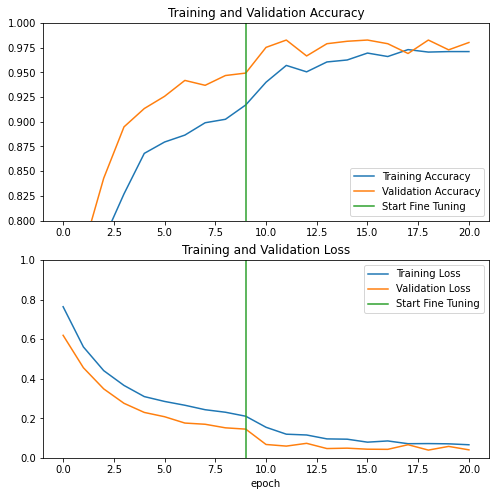

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

In [37]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/6 [====>.........................] - ETA: 2s - loss: 0.0876 - accuracy: 0.9688

2/6 [=========>....................] - ETA: 0s - loss: 0.0471 - accuracy: 0.9844

3/6 [==============>...............] - ETA: 0s - loss: 0.0398 - accuracy: 0.9896

4/6 [===================>..........] - ETA: 0s - loss: 0.0359 - accuracy: 0.9844

5/6 [========================>.....] - ETA: 0s - loss: 0.0320 - accuracy: 0.9875

6/6 [==============================] - ETA: 0s - loss: 0.0559 - accuracy: 0.9792

6/6 [==============================] - 1s 188ms/step - loss: 0.0559 - accuracy: 0.9792


Test accuracy : 0.9791666865348816


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [0 1 0 0 1 1 1 1 1 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 0 1 1 0 1 0 0 0]
Labels:
 [0 1 0 0 1 1 1 1 1 0 0 1 0 1 1 1 0 0 1 0 1 0 1 0 0 1 1 0 1 0 0 0]


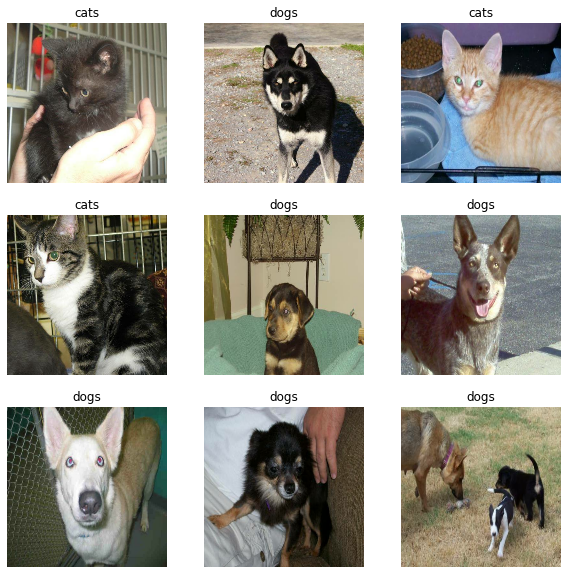

In [38]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
# TODO
# TODO: Your code goes here
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).


Copyright 2021 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License